# Statistical Pattern Recognition: Assignment 4
**Title**    : Linear classifiers

**Members**  : Jayanth S, Praveen Kumar N, Rishabh Roy

# Importing

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,plot_confusion_matrix

from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

import numpy as np
import pandas as pd
import math 
from   numpy.random import rand

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Javascript
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Linear classifiers built from scratch:

## Perceptron:

In [ ]:
class MyPerceptron():

    def __init__(self):
        self.w_est = None    # Estimated weight vector
        self.eta   = None    # Learning rate
        self.N_epochs = None # Number of epochs for Stochastic gradient descent
        self.miss_class = None  # List to store number of missclassifications in each epoch
        self.n     = None    # Number of Training samples
        self.d     = None    # Dimension of feature vector
  
    
    def Perceptron_estimate(self, X_aug, y):

        '''
            Inputs          -> Augmented Matrix(X) and true labels vector(y)
            Outputs         -> Estimated weight vector using Stochastic gradient descent(w_est)
                               List of missclassifications at each epoch
            Perceptron update rule -> w_(t+1) = w_(t) + eta * X_aug^T(y - y_est)/2*n 
                                      w_(t+1) = w_(t) - eta * X_aug^T(y_est - y)/2*n
                                   This update rule ensures that the weight vector obtained will give
                                   zero missclassifications if the classes are "linearly separable"
        '''

        miss_class  = list()      # List to store the number of missclassifications at each epoch
        np.random.seed(0)
        w_est = rand(self.d+1,1)  # Initialization of weight vector to random values 

        for _ in range(self.N_epochs):  
          
            # Estimated outputs using weight vector "w_est"
            y_est    = np.sign(X_aug @ w_est) # (n X d+1).(d+1 X 1) -> (n X 1)
            # Error in the Estimated outputs 
            error    = y_est - y                # (n X 1)

            # Weight vector update
            dw       = (X_aug.T @ error) /(2*self.n)
            w_est    = w_est - self.eta*dw    # (d+1 X 1)        
          
            # Storing the Binary Cross-Entropy Loss value for the current weight vector(current epoch)
            miss_class.append(self.Num_miss_class(X_aug, y, w_est)) 
            
            # Stopping criteria
            if np.linalg.norm(dw) < 10**(-5):
                break

        return w_est,miss_class

    def Num_miss_class(self,X_aug,y,w_est):
      
        '''
           Output -> Num_miss_class : Number of samples missclassifeid by the estimated weight vector "w_est" 
        '''

        y_est  = X_aug @ w_est  # (n X d+1).(d+1 X 1) -> (n X 1) 
        N_miss_class = np.sum(y_est!=y)         

        return N_miss_class

    def fit(self, X, y,eta,N_epochs):

        '''
            X : Matrix containing training feature vectors in each row
              size of matrix -> (n X d) where n -> number of training samples, d -> feature vector dimension
            y : Vector containing true labels of the n training samples (labels -> -1(class 0) , +1(class 1))
              size of vector -> (n X 1)     
          eta : Learning rate
          N_epochs : Number of epochs        
        '''
      
        self.eta      = eta
        self.N_epochs = N_epochs
        self.n        = np.shape(X)[0] 
        self.d        = np.shape(X)[1]  
        X_aug         = np.concatenate((np.ones((self.n,1), dtype=int),X), axis=1) # (n X d+1)

        w_est,miss_class = self.Perceptron_estimate(X_aug, y)
        self.w_est       = w_est
        self.miss_class  = miss_class

    def predict(self, X):

        '''
           Input  -> X      : Matrix containing testing feature vectors in each row
                              size of matrix -> (n_test X d) where n_test -> number of testing samples, d -> feature vector dimension
           Output -> y_pred : Vector containing predicted labels of the n_test testing samples 
                              size of vector -> (n_test X 1)     
        '''
        
        n_test = np.shape(X)[0]
        X_aug  = np.concatenate((np.ones((n_test,1), dtype=int),X), axis=1)
        
        # Perceptron outputs obtained using estimated weight vector 
        y_pred  = np.sign(X_aug@self.w_est) # (n_test X d+1) . (d+1 X 1) -> (n_test X 1)
        y_pred[y_pred == 0] = 1             # when the predicted output is 0 classify it as class 1          
        
        return y_pred

    def Accuracy(self,X,y):

        '''
            Inputs  -> X : Matrix containing testing feature vectors in each row, size of matrix -> (n X d) 
                       y : Vector containing the true class labels of the feature vectors, size of the vector -> (n x 1)        
            Output  -> Accuracy of the estimated weight vector "w_est" on the given samples     
        '''

        # Predict the class labels using "w_est" (estimated weight vector)
        y_pred   = self.predict(X)

        accuracy = accuracy_score(y,y_pred)*100

        return accuracy

## Fischer linear discriminant:

In [ ]:
class FLD():
  
  def __init__(self):
        self.w_est = None    # Estimated weight vector
        self.n     = None    # Number of Training samples
        self.d     = None    # Dimension of feature vector

  def estimate_weight_vector(self, X, y):
        
        '''
            Inputs -> training Matrix(X) and true labels vector(y)
            Output -> w_est: estimated weight vector according to fischer linear discriminant analysis
        '''

        C0_samples = X[np.where(y == 0)[0],:].T # Class 0 samples in training data
        C1_samples = X[np.where(y == 1)[0],:].T # Class 1 samples in training data

        #find the mean of class 0(M0) and mean of class 1(M1)
        M0 = np.mean(C0_samples,axis=1,keepdims = 1)   # (d X 1)
        M1 = np.mean(C1_samples,axis=1,keepdims = 1)   # (d X 1)

        #difference between class means
        mu_diff = M1-M0  # (d X 1)

        #within class matrix
        SW =  (C0_samples - M0) @ (C0_samples - M0).T + (C1_samples - M1) @ (C1_samples - M1).T # (d X d)
        
        #Optimal weight vector : inv(SW) x (M1 - M0)
        w = np.linalg.inv(SW+ np.identity(self.d)) @ mu_diff # (d X 1)

        #Optimal offset for the hyperplane
        M = ((C0_samples.shape[1]*M0 + C1_samples.shape[1]*M1)/(self.n)) # Mean of all the training samples
        b = -w.T@M  

        return b,w  

  def fit(self, X, y):

        '''
           X : Matrix containing training feature vectors in each row
               size of matrix -> (n X d) where n -> number of training samples, d -> feature vector dimension
           y : Vector containing true labels of the n training samples (labels -> 0(class 0) , 1(class 1))
               size of vector -> (n X 1)     
        '''
        self.d = np.shape(X)[1]   
        self.n = np.shape(X)[0]

        b,w = self.estimate_weight_vector(X, y)  # (d+1 X 1)

        self.w_est = np.expand_dims(np.append(b,w),axis=-1)


  def predict(self, X):

        '''
           Input  -> X      : Matrix containing testing feature vectors in each row
                              size of matrix -> (n_test X d) where n_test -> number of testing samples, d -> feature vector dimension
           Output -> y_pred : Vector containing predicted labels of the n_test testing samples 
                              size of vector -> (n_test X 1)     
        '''
        
        n_test = np.shape(X)[0]
        X_aug  = np.concatenate((np.ones((n_test,1), dtype=int),X), axis=1)
        
        # Threshold FLD outputs obtained using estimated weight vector 
        y_tmp  = X_aug @ self.w_est    # (n_test X d+1) . (d+1 X 1) -> (n_test X 1)
        y_pred = np.where(y_tmp<0,0,1)          
        
        return y_pred 

  def Accuracy(self,X,y):

        '''
            Inputs  -> X : Matrix containing testing feature vectors in each row, size of matrix -> (n X d) 
                       y : Vector containing the true class labels of the feature vectors, size of the vector -> (n x 1)        
            Output  -> Accuracy of the estimated weight vector "w_est" on the given samples     
        '''

        # Predict the class labels using "w_est" (estimated weight vector)
        y_pred   = self.predict(X)

        accuracy = accuracy_score(y,y_pred)*100

        return accuracy           

## Linear regression:

In [ ]:
class MultipleLinearRegression():

    def __init__(self):
        self.w_est = None  # Estimated weight vector
        self.n     = None  # Number of Training samples
        self.d     = None  # Dimension of feature vector
        
    def estimate_weight_vector(self, X_aug, y):
        
        '''
            Inputs -> Augmented training Matrix(X_aug) and true labels vector(y)
            Output -> w_est = (X_aug^TX_aug)^-1 X_aug^Ty(Linear least squares solution)
        '''

        inv    = np.linalg.inv( X_aug.T @ X_aug + np.identity(self.d+1)) # a@b -> a.dot(b) -> dot(a,b)
        w_est  = inv @ X_aug.T @ y                # (d+1 X 1)

        return w_est  

    def fit(self, X, y):

        '''
           X : Matrix containing training feature vectors in each row
               size of matrix -> (n X d) where n -> number of training samples, d -> feature vector dimension
           y : Vector containing true labels of the n training samples (labels -> -1(class 0) , +1(class 1))
               size of vector -> (n X 1)     
        '''

        self.n = np.shape(X)[0]
        self.d = np.shape(X)[1] 
        X_aug  = np.concatenate((np.ones((self.n,1), dtype=int),X), axis=1) # (n X d+1)

        self.w_est = self.estimate_weight_vector(X_aug, y)                  # (d+1 X 1)

    def predict(self, X):

        '''
            Input  -> X      : Matrix containing testing feature vectors in each row
                               size of matrix -> (n_test X d) where n_test -> number of testing samples, d -> feature vector dimension
            Output -> y_pred : Vector containing predicted labels of the n_test testing samples 
                               size of vector -> (n_test X 1)     
        '''
        
        n_test = np.shape(X)[0]
        X_aug  = np.concatenate((np.ones((n_test,1), dtype=int),X), axis=1)
        
        # Regression outputs obtained using estimated weight vector 
        y_tmp  = X_aug@self.w_est    # (n_test X d+1) . (d+1 X 1) -> (n_test X 1)

        # Threshold the regression outputs to get the classifier outputs    
        y_pred = np.sign(y_tmp) 
        y_pred[y_pred == 0] = 1 # when the regression output is 0 classify it as class 1          
        
        return y_pred

    def Accuracy(self,X,y):

        '''
            Inputs  -> X : Matrix containing testing feature vectors in each row, size of matrix -> (n X d) 
                       y : Vector containing the true class labels of the feature vectors, size of the vector -> (n x 1)        
            Output  -> Accuracy of the estimated weight vector "w_est" on the given samples     
        '''

        # Predict the class labels using "w_est" (estimated weight vector)
        y_pred   = self.predict(X)

        accuracy = accuracy_score(y,y_pred)*100

        return accuracy


## Logistic regression:

In [ ]:
class MyLogisticRegression():

    def __init__(self):
        self.w_est = None    # Estimated weight vector
        self.eta   = None    # Learning rate
        self.N_epochs = None # Number of epochs for Stochastic gradient descent
        self.loss  = None    # List to store loss in each epoch
        self.n     = None    # Number of Training samples
        self.d     = None    # Dimension of feature vector

    def sigmoid(self, x): 
        return 1 / (1 + np.e**(-x)) 

    def SGD_estimate(self, X_aug, y):

        '''
            Inputs          -> Augmented Matrix(X) and true labels vector(y)
            Outputs         -> Estimated weight vector using Stochastic gradient descent(w_est)
                                 List of loss incurred at each epoch
            SGD update rule -> w_(t+1) = w_(t) - eta * X_aug^T(y_est - y)/n  
                               This update rule ensures that we minimize the Binary Cross-Entropy Loss Function         
        '''

        loss  = list()            # List to store the loss incurred at each epoch
        np.random.seed(0)
        w_est = rand(self.d+1,1)  # Initialization of weight vector to random values 

        for _ in range(self.N_epochs):  
          
            # Estimated outputs using weight vector "w_est"
            y_est    = self.sigmoid(X_aug @ w_est)  # (n X d+1).(d+1 X 1) -> (n X 1)
            # Error in the Estimated outputs 
            error    = y_est - y                    # (n X 1)

            # Weight vector update
            w_est    = w_est - self.eta*(X_aug.T @ error) / self.n  # (d+1 X 1)        
          
            # Storing the Binary Cross-Entropy Loss value for the current weight vector(current epoch)
            loss.append(self.Cross_entropy_cost(X_aug, y, w_est)) 

        return w_est,loss

    def Cross_entropy_cost(self,X_aug,y,w_est):
      
        '''
           Output -> loss : Binary Cross-Entropy Loss corresponding to the estimated weight vector "w_est"  
        '''

        z      = X_aug @ w_est                         # (n X d+1).(d+1 X 1) -> (n X 1) 
        loss_1 = y * np.log(self.sigmoid(z)+10**(-5))  # (n X 1)*(n X 1) -> (n X 1)[element wise multiplication]
        loss_0 = (1 - y) * np.log(1 - self.sigmoid(z)+10**(-5)) # (n X 1)*(n X 1) -> (n X 1)[element wise multiplication]
        loss   = -sum(loss_1 + loss_0) /self.n         # Binary Cross-Entropy Loss

        return loss

    def fit(self, X, y,eta,N_epochs):

        '''
            X   : Matrix containing training feature vectors in each row
                size of matrix -> (n X d) where n -> number of training samples, d -> feature vector dimension
            y   : Vector containing true labels of the n training samples (labels -> 0(class 0) , 1(class 1))
                size of vector -> (n X 1) 
            eta : Learning rate
            N_epochs : Number of epochs        
        '''
      
        self.eta      = eta
        self.N_epochs = N_epochs
        self.n        = np.shape(X)[0] 
        self.d        = np.shape(X)[1]  
        X_aug         = np.concatenate((np.ones((self.n,1), dtype=int),X), axis=1) # (n X d+1)

        w_est,loss = self.SGD_estimate(X_aug, y)
        self.w_est = w_est
        self.loss  = loss

    def predict(self, X):

        '''
            Input  -> X      : Matrix containing testing feature vectors in each row
                             size of matrix -> (n_test X d) where n_test -> number of testing samples, d -> feature vector dimension
            Output -> y_pred : Vector containing predicted labels of the n_test testing samples 
                             size of vector -> (n_test X 1)     
        '''
      
        n_test   = np.shape(X)[0]      
        X_aug    = np.concatenate((np.ones((n_test,1), dtype=int),X), axis=1) # (n X d+1)

        # Computing regression outputs using estimated weight vector
        z      = X_aug @ self.w_est  # (n_test X d+1).(d+1 X 1) -> (n_test X 1)
        y_tmp  = self.sigmoid(z)

        # Threshold the obtained outputs to get predicted class labels(0 or 1)
        y_pred = np.where(y_tmp<0.5,0,1)

        return y_pred

    def Accuracy(self,X,y):

        '''
            Inputs  -> X : Matrix containing testing feature vectors in each row, size of matrix -> (n X d) 
                       y : Vector containing the true class labels of the feature vectors, size of the vector -> (n x 1)        
            Output  -> Accuracy of the estimated weight vector "w_est" on the given samples     
        '''

        # Predict the class labels using "w_est" (estimated weight vector)
        y_pred   = self.predict(X)

        accuracy = accuracy_score(y,y_pred)*100

        return accuracy   

# Supporting functions:

## Multivariate gaussian data generation:


In [ ]:
def generate_data(N_train,N_test,mu,covariance,p):

    '''
      Inputs:
      N_train, N_test : Number of training and testing samples required
      mu              : Matrix containing mean vectors for each class
                        size of mu -> (c X d), where d is the dimension of feature vector, c is number of classes(2 here)
      covariance      : list of covariance matrices of different classes
                        size of each covariance matrix -> (d x d), length of covariance list -> c(2 here)
      p               : list containing prior probabilities of each class
                        length of list p -> c(2 here) 
      Outputs:
      train_samples : Matrix containing feature vectors from different classes according to prior probability 'p' for training
                      size of Matrix -> (N_train X d)
      train_labels  : Vector of corresponding labels for the train_samples
                      size of vector -> (N_train X 1) 
      test_samples  : Matrix containing feature vectors from different classes according to prior probability 'p' for testing
                      size of Matrix -> (N_test X d)
      test_labels   : Vector of corresponding labels for the test_samples
                      size of vector -> (N_test X 1)                               
    '''

    train_samples = list()
    train_labels =  list()

    for i in range(N_train):

        class_selected = np.random.choice([0,1],p=p)
        mu_sel         = mu[class_selected,:]
        temp_sample    = np.random.multivariate_normal(mu_sel,covariance[class_selected])
        train_samples.append(temp_sample)
        train_labels.append(class_selected)
    
    train_samples = np.array(train_samples) 
    train_labels  = np.expand_dims(np.array(train_labels),axis=-1)    

    test_samples = list()
    test_labels  = list()

    for i in range(N_test):

        class_selected = np.random.choice([0,1],p=p)
        mu_sel         = mu[class_selected,:]
        temp_sample    = np.random.multivariate_normal(mu_sel,covariance[class_selected])
        test_samples.append(temp_sample)
        test_labels.append(class_selected)
    
    test_samples = np.array(test_samples)   
    test_labels  = np.expand_dims(np.array(test_labels),axis=-1) 
    
    N = N_train+N_test
    print(f"train-test split : {int((N_train/N)*100)}:{int((N_test/N)*100)}\n")
    print(f"Number of training data points : {train_samples.shape[0]}")
    print(f"Number of test data points  : {test_samples.shape[0]}")
    print(f"Dimension of feature vectors : {train_samples.shape[1]}\n") 

    return train_samples,train_labels,test_samples,test_labels

## Data preprocessing:

### German credit card data:

In [153]:
def German_data_numeric_preprocessing(testdata_per):
  
    '''
      Inputs:
      testdata_per  : proprtion of test data for splitting data into train and test data

      Outputs:
      train_samples : Matrix containing feature vectors from different classes
                      size of Matrix -> (N_train X d)
      train_labels  : Vector of corresponding labels for the train_samples
                      size of vector -> (N_train X 1) 
      test_samples  : Matrix containing feature vectors from different classes
                      size of Matrix -> (N_test X d)
      test_labels   : Vector of corresponding labels for the test_samples
                      size of vector -> (N_test X 1) 
      Here N_train -> Number training data points(N*(1-testdata_per)) , N_test -> Number of test data points(N*testdata_per)
           N_train + N_test = N = 1000 for german credit data
           d -> dimension of each feature vector = 20 for german credit data                                                       
    '''

    german_data = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/German_credit_data/german_credit_data.csv")

    labels      = german_data['Creditability']  #obtain the values(labels) from the 'Creditability' column

    german_data = german_data.drop(['Creditability'],axis = 1)  # remove the 'Creditability' column from the data

    scaler = StandardScaler()
    scaler.fit(german_data)
    german_data = scaler.transform(german_data)

    train_samples, test_samples, train_labels, test_labels = train_test_split(german_data, labels, test_size = testdata_per)
    train_labels = np.expand_dims(train_labels,axis=-1) # (1000*(1-testdata_per) X 1)
    test_labels  = np.expand_dims(test_labels,axis=-1)  # (1000*testdata_per X 1)

    prob_cat = [np.count_nonzero(labels == cat)/len(labels) for cat in np.unique(labels)]
    
    print(f"class probabilities: p0 = {prob_cat[0]},p1 = {prob_cat[1]}")
    print(f"For train-test split : {int((1-testdata_per)*100)}:{int(testdata_per*100)}\n")
    print(f"Number of training data points : {train_samples.shape[0]}")
    print(f"Number of test data points  : {test_samples.shape[0]}")
    print(f"Dimension of feature vectors : {train_samples.shape[1]}\n")
    
    return train_samples,train_labels,test_samples,test_labels

### Porto-seguro Safe driver prediction data:

In [154]:
def Safe_driver_prediction_preprocessing(testdata_per):
    
    '''
      Inputs:
      testdata_per  : proprtion of test data for splitting data into train and test data

      Outputs:
      train_samples : Matrix containing feature vectors from different classes
                      size of Matrix -> (N_train X d)
      train_labels  : Vector of corresponding labels for the train_samples
                      size of vector -> (N_train X 1) 
      test_samples  : Matrix containing feature vectors from different classes
                      size of Matrix -> (N_test X d)
      test_labels   : Vector of corresponding labels for the test_samples
                      size of vector -> (N_test X 1) 
      Here N_train -> Number training data points(N*(1-testdata_per)) , N_test -> Number of test data points(N*testdata_per)
           N = 595212 (before sampling) , N = 43388(after down sampling)
           d -> dimension of each feature vector = 54 safe driver prediction data                                                          
    '''

    driver_data = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/Safe_driver_prediction/train.csv")

    labels      = driver_data['target']  #obtain the values(labels) from the 'target' column

    # remove the 'target' column  and other unwanted columns from the data
    # unwanted columns : which if of no use in classification 

    unwanted    = ['target','id','ps_ind_07_bin','ps_ind_08_bin','ps_ind_09_bin']
    driver_data = driver_data.drop(unwanted,axis = 1)

    rus = RandomUnderSampler(random_state=1)
    rus.fit(driver_data, labels)
    resampled_data, resampled_labels = rus.fit_sample(driver_data, labels)

    scaler = StandardScaler()
    scaler.fit(resampled_data)
    resampled_data = scaler.transform(resampled_data)

    train_samples, test_samples, train_labels, test_labels = train_test_split(resampled_data, resampled_labels, test_size = testdata_per)
    train_labels = np.expand_dims(train_labels,axis=-1) # (43388*(1-testdata_per) X 1)
    test_labels  = np.expand_dims(test_labels,axis=-1)  # (43388*testdata_per X 1)
    
    prob_cat = [np.count_nonzero(labels == cat)/len(labels) for cat in np.unique(labels)]
    prob_cat_resam = [np.count_nonzero(resampled_labels == cat)/len(resampled_labels) for cat in np.unique(resampled_labels)]
    
    print(f"class probabilities : p0 = {prob_cat[0]},p1 = {prob_cat[1]}")
    print(f"class probabilities after under sampling: p0 = {prob_cat_resam[0]},p1 = {prob_cat_resam[1]}")
    print(f"For train-test split : {int((1-testdata_per)*100)}:{int(testdata_per*100)}\n")
    print(f"Number of training data points : {train_samples.shape[0]}")
    print(f"Number of test data points  : {test_samples.shape[0]}")
    print(f"Dimension of feature vectors : {train_samples.shape[1]}\n")

    return train_samples,train_labels,test_samples,test_labels

## Perceptron testing function: 

In [ ]:
def Perceptron_testing(train_samples,train_labels,test_samples,test_labels,eta,N_epochs):
        
        # Dimension of the feature vector
        d = np.shape(train_samples)[1]
        # Converting class labels from 0 or 1 to -1 or +1
        ntrain_labels = 2*train_labels - 1          
        ntest_labels  = 2*test_labels - 1
        
        print("*********** PERCEPTRON *************\n")
        ## Using IN-BUILT classifier (Fits linear model with Stochastic Gradient Descent)

        # Creating class object
        per_cls_in    = Perceptron()  

        # Estimate the weight vector
        per_cls_in.fit(train_samples,ntrain_labels.ravel()) 
            
        # Computing the accuracy of the estimated weight vector
        y_pred_train = per_cls_in.predict(train_samples)
        y_pred_test  = per_cls_in.predict(test_samples)
        train_accuracy_per_in = accuracy_score(ntrain_labels,y_pred_train.ravel())*100
        test_accuracy_per_in  = accuracy_score(ntest_labels,y_pred_test.ravel())*100

        # Number of iterations run by in-built classifier to get optimal weight vector
        # N_epochs = per_cls_in.n_iter_ 

        ## Using classifier built from scratch

        # Creating class object
        per_cls    = MyPerceptron()  

        # Estimate the weight vector
        per_cls.fit(train_samples,ntrain_labels,eta,N_epochs) 

        # Computing the accuracy of the estimated weight vector
        train_accuracy_per = per_cls.Accuracy(train_samples,ntrain_labels)
        test_accuracy_per  = per_cls.Accuracy(test_samples,ntest_labels)

        N_train = np.shape(train_samples)[0] 
        N_test  = np.shape(test_samples)[0]
        N = N_train+N_test
        print(f"train-test split : {math.ceil((N_train/N)*100)}:{math.ceil((N_test/N)*100)}, Learning rate : {eta}, Number of epochs : {N_epochs}\n")
        print("Using classifier built from scratch")
        print(f"Train accuracy= {train_accuracy_per:.2f} %")
        print(f"Test accuracy = {test_accuracy_per:.2f}%")
        
        return per_cls_in,per_cls
        

## FLD testing:

In [ ]:
def FLD_testing(train_samples,train_labels,test_samples,test_labels):
        
        # Dimension of the feature vector
        d = np.shape(train_samples)[1]
        
        print("*********** FLD *************\n")
        ## Using classifier built from scratch

        # Creating class object
        fld_cls    = FLD()  

        # Estimate the weight vector
        fld_cls.fit(train_samples,train_labels) 

        # Computing the accuracy of the estimated weight vector
        train_accuracy_fld = fld_cls.Accuracy(train_samples,train_labels)
        test_accuracy_fld  = fld_cls.Accuracy(test_samples,test_labels)

        N_train = np.shape(train_samples)[0] 
        N_test  = np.shape(test_samples)[0]
        N = N_train+N_test
        print(f"train-test split : {math.ceil((N_train/N)*100)}:{math.ceil((N_test/N)*100)}\n")
        print("Using classifier built from scratch")
        print(f"Train accuracy= {train_accuracy_fld:.2f} %")
        print(f"Test accuracy = {test_accuracy_fld:.2f}%")
        
        return fld_cls

## Linear regression testing function: 

In [ ]:
def Linreg_testing(train_samples,train_labels,test_samples,test_labels):
        
        # Dimension of the feature vector
        d = np.shape(train_samples)[1]
        # Converting class labels from 0 or 1 to -1 or +1
        ntrain_labels = 2*train_labels - 1          
        ntest_labels  = 2*test_labels - 1

        print("*********** LINEAR REGRESSION *************\n")
        ## Using IN-BUILT classifier

        # Creating class object
        linreg_cls_in    = LinearRegression()  

        # Estimate the weight vector
        linreg_cls_in.fit(train_samples,ntrain_labels.ravel()) 

        # Computing the accuracy of the estimated weight vector
        y_pred_train = linreg_cls_in.predict(train_samples)
        y_pred_train = np.sign(y_pred_train) 
        y_pred_train[y_pred_train == 0] = 1
        y_pred_test  = linreg_cls_in.predict(test_samples)
        y_pred_test = np.sign(y_pred_test) 
        y_pred_test[y_pred_test == 0] = 1
        train_accuracy_linreg_in = accuracy_score(ntrain_labels,y_pred_train.ravel())*100
        test_accuracy_linreg_in  = accuracy_score(ntest_labels,y_pred_test.ravel())*100

        ## Using classifier built from scratch

        # Creating class object
        linreg_cls    = MultipleLinearRegression()  

        # Estimate the weight vector
        linreg_cls.fit(train_samples,ntrain_labels) 

        # Computing the accuracy of the estimated weight vector
        train_accuracy_linreg = linreg_cls.Accuracy(train_samples,ntrain_labels)
        test_accuracy_linreg  = linreg_cls.Accuracy(test_samples,ntest_labels)
        
        N_train = np.shape(train_samples)[0] 
        N_test  = np.shape(test_samples)[0]
        N = N_train+N_test
        print(f"train-test split : {math.ceil((N_train/N)*100)}:{math.ceil((N_test/N)*100)}\n")
        print("Using IN-BUILT classifier")
        print(f"Train accuracy= {train_accuracy_linreg_in:.2f} %")
        print(f"Test accuracy = {test_accuracy_linreg_in:.2f} %")
        print("Using classifier built from scratch")
        print(f"Train accuracy= {train_accuracy_linreg:.2f} %")
        print(f"Test accuracy = {test_accuracy_linreg:.2f} %")
    
        return linreg_cls_in,linreg_cls

## Logistic regression testing function: 

In [ ]:
def Logreg_testing(train_samples,train_labels,test_samples,test_labels,eta,N_epochs,loss_plot = True):

        # Dimension of the feature vector
        d = np.shape(train_samples)[1]
        print("*********** LOGISTIC REGRESSION *************\n")
        ## Using IN-BUILT classifier

        # Creating class object
        logreg_cls_in    = LogisticRegression()  
    
        # Estimate the weight vector
        logreg_cls_in.fit(train_samples,train_labels.ravel()) 

        # Computing the accuracy of the estimated weight vector
        y_pred_train = logreg_cls_in.predict(train_samples)
        y_pred_test  = logreg_cls_in.predict(test_samples)
        train_accuracy_logreg_in = accuracy_score(train_labels,y_pred_train.ravel())*100
        test_accuracy_logreg_in  = accuracy_score(test_labels,y_pred_test.ravel())*100

        ## Using classifier built from scratch

        # Creating class object
        logreg_cls    = MyLogisticRegression()  

        # Estimate the weight vector
        logreg_cls.fit(train_samples,train_labels,eta,N_epochs) 

        # Computing the accuracy of the estimated weight vector
        train_accuracy_logreg = logreg_cls.Accuracy(train_samples,train_labels)
        test_accuracy_logreg  = logreg_cls.Accuracy(test_samples,test_labels)
        
        N_train = np.shape(train_samples)[0] 
        N_test  = np.shape(test_samples)[0]
        N = N_train+N_test
        print(f"train-test split : {math.ceil((N_train/N)*100)}:{math.ceil((N_test/N)*100)}, Learning rate : {eta}, Number of epochs : {N_epochs}\n")
        print("Using IN-BUILT classifier")
        print(f"Train accuracy= {train_accuracy_logreg_in:.2f} %")
        print(f"Test accuracy = {test_accuracy_logreg_in:.2f} %")
        print("Using classifier built from scratch")
        print(f"Train accuracy= {train_accuracy_logreg:.2f} %")
        print(f"Test accuracy = {test_accuracy_logreg:.2f} %")
        
        if (loss_plot == True):
            # Plotting loss values vs Epoch number
            loss = logreg_cls.loss
            plt.plot(loss)
            plt.title("Binary cross entropy loss values vs Epoch number")
            plt.xlabel("Epoch number")
            plt.ylabel("Loss value")
            
        return logreg_cls_in,logreg_cls

## Results plotting function: 

In [ ]:
def plot_res(per_cls,fld_cls,linreg_cls,logreg_cls,per_cls_in,linreg_cls_in,logreg_cls_in,train_samples,train_labels,test_samples,test_labels):
        
        ntest_labels  = 2*test_labels - 1
        min_x    = np.min(test_samples[:,0])
        max_x    = np.max(test_samples[:,0])
        x        = np.arange(start = min_x,stop =max_x)
        
        w_est_per    = per_cls.w_est    # estimated weight vector from perceptron
        w_est_fld    = fld_cls.w_est    # estimated weight vector from FLDA
        w_est_linreg = linreg_cls.w_est # estimated weight vector from Linear regression
        w_est_logreg = logreg_cls.w_est # estimated weight vector from Logistic regression
        

        # Seperating hyperplanes obtained from classifiers built from scratch
        h_per    =-(w_est_per[0]+w_est_per[1]*x)/w_est_per[2]          # Hyperplane obtained from Perceptron
        h_fld    =-(w_est_fld[0]+w_est_fld[1]*x)/w_est_fld[2]          # Hyperplane obtained from FLDA
        h_linreg =-(w_est_linreg[0]+w_est_linreg[1]*x)/w_est_linreg[2] # Hyperplane obtained from Linear regression
        h_logreg =-(w_est_logreg[0]+w_est_logreg[1]*x)/w_est_logreg[2] # Hyperplane obtained from Logistic regression
        
        # estimated weight vector from perceptron(IN-BUILT)
        w   = per_cls_in.coef_
        w_0 = np.expand_dims(per_cls_in.intercept_,axis=-1)
        w_est_per_in = np.expand_dims(np.append(w_0,w),axis=-1)
        
        # estimated weight vector from Linear regression(IN-BUILT)
        w   = linreg_cls_in.coef_
        w_0 = np.expand_dims(linreg_cls_in.intercept_,axis=-1)
        w_est_linreg_in = np.expand_dims(np.append(w_0,w),axis=-1)
        
        # estimated weight vector from Logistic regression(IN-BUILT)
        w   = logreg_cls_in.coef_
        w_0 = np.expand_dims(logreg_cls_in.intercept_,axis=-1)
        w_est_logreg_in = np.expand_dims(np.append(w_0,w),axis=-1)

        # Seperating hyperplanes obtained from IN-BUILT classifiers   
        h_per_in    =-(w_est_per_in[0]+w_est_per_in[1]*x)/w_est_per_in[2]          # Hyperplane obtained from Perceptron(IN-BUILT)
        h_linreg_in =-(w_est_linreg_in[0]+w_est_linreg_in[1]*x)/w_est_linreg_in[2] # Hyperplane obtained from Linear regression(IN-BUILT)
        h_logreg_in =-(w_est_logreg_in[0]+w_est_logreg_in[1]*x)/w_est_logreg_in[2] # Hyperplane obtained from Logistic regression(IN-BUILT)
        
        avoid_scroll_output_window()

        ## Training data

        train_cls_0 = train_samples[np.where(train_labels == 0)[0],:] # Class 0 samples in training data
        train_cls_1 = train_samples[np.where(train_labels == 1)[0],:] # Class 1 samples in training data

        # Plotting obtained hyperplanes on training samples
        plt.figure(figsize=(8,8))
        plt.scatter(train_cls_0[:,0],train_cls_0[:,1], marker='+',label = 'class 0')
        plt.scatter(train_cls_1[:,0],train_cls_1[:,1], c= 'green', marker='+',label = 'class 1')
        sns.lineplot(x=x,y=h_per,legend = 'brief', label ='Hyperplane obtained from Perceptron',linewidth = 2,color='pink')
        sns.lineplot(x=x,y=h_fld,legend = 'brief', label ='Hyperplane obtained from FLDA',linewidth = 2,color='purple')
        sns.lineplot(x=x,y=h_linreg,legend = 'brief', label ='Hyperplane obtained from Linear regression',linewidth = 2,color='black')
        sns.lineplot(x=x,y=h_logreg,legend = 'brief', label ='Hyperplane obtained from Logistic regression',linewidth = 2,color='orange')
        plt.title("Training data(p0:{}, p1:{})".format(p0,p1),fontsize=18, fontweight='bold')
        plt.legend()
        plt.show()

        ## Test data

        test_cls_0 = test_samples[np.where(test_labels == 0)[0],:] # Class 0 samples in test data
        test_cls_1 = test_samples[np.where(test_labels == 1)[0],:] # Class 1 samples in test data

        # Plotting test data samples
        plt.figure(figsize=(8,8))
        plt.scatter(test_cls_0[:,0],test_cls_0[:,1], marker='+',label = 'class 0')
        plt.scatter(test_cls_1[:,0],test_cls_1[:,1], c= 'green', marker='+',label = 'class 1')
        plt.title("Test data(p0:{}, p1:{})".format(p0,p1),fontsize=18, fontweight='bold')
        plt.legend()
        plt.show()

        # Perceptron on test samples
        y_pred          = per_cls.predict(test_samples)
        pred_test_cls_0 = test_samples[np.where(y_pred == -1)[0],:] # Predicted class 0 samples in test data
        pred_test_cls_1 = test_samples[np.where(y_pred == 1)[0],:]  # Predicted class 1 samples in test data

        # Plotting hyperplane obtained from perceptron regression on test samples
        plt.figure(figsize=(8,8))
        plt.scatter(pred_test_cls_0[:,0],pred_test_cls_0[:,1], marker='+',label = 'Predicted as class 0')
        plt.scatter(pred_test_cls_1[:,0],pred_test_cls_1[:,1], c= 'green', marker='+',label = 'Predicted as class 1')
        sns.lineplot(x=x,y=h_per,legend = 'brief', label ='Hyperplane obtained from Perceptron',linewidth = 3,color='pink')
        # Computing the accuracy of the estimated weight vector
        test_accuracy_per  = per_cls.Accuracy(test_samples,ntest_labels)
        plt.title("Perceptron classifier on test data(Accuracy:{:.2f} %)".format(test_accuracy_per),fontsize=18, fontweight='bold')
        plt.legend()
        plt.show()

        # FLDA on test samples
        y_pred          = fld_cls.predict(test_samples)
        pred_test_cls_0 = test_samples[np.where(y_pred == 0)[0],:] # Predicted class 0 samples in test data
        pred_test_cls_1 = test_samples[np.where(y_pred == 1)[0],:] # Predicted class 1 samples in test data

        # Plotting hyperplane obtained from FLDA on test samples
        plt.figure(figsize=(8,8))
        plt.scatter(pred_test_cls_0[:,0],pred_test_cls_0[:,1], marker='+',label = 'Predicted as class 0')
        plt.scatter(pred_test_cls_1[:,0],pred_test_cls_1[:,1], c= 'green', marker='+',label = 'Predicted as class 1')
        sns.lineplot(x=x,y=h_fld,legend = 'brief', label ='Hyperplane obtained from FLDA',linewidth = 3,color='purple')
        # Computing the accuracy of the estimated weight vector
        test_accuracy_fld  = fld_cls.Accuracy(test_samples,test_labels)
        plt.title("FLD classifier on test data(Accuracy:{:.2f} %)".format(test_accuracy_fld),fontsize=18, fontweight='bold')
        plt.legend()
        plt.show()

        # Linear regression on test samples
        y_pred          = linreg_cls.predict(test_samples)
        pred_test_cls_0 = test_samples[np.where(y_pred == -1)[0],:] # Predicted class 0 samples in test data
        pred_test_cls_1 = test_samples[np.where(y_pred == 1)[0],:]  # Predicted class 1 samples in test data

        # Plotting hyperplane obtained from linear regression on test samples
        plt.figure(figsize=(8,8))
        plt.scatter(pred_test_cls_0[:,0],pred_test_cls_0[:,1], marker='+',label = 'Predicted as class 0')
        plt.scatter(pred_test_cls_1[:,0],pred_test_cls_1[:,1], c= 'green', marker='+',label = 'Predicted as class 1')
        sns.lineplot(x=x,y=h_linreg,legend = 'brief', label ='Hyperplane obtained from Linear regression',linewidth = 3,color='black')
        # Computing the accuracy of the estimated weight vector
        test_accuracy_linreg  = linreg_cls.Accuracy(test_samples,ntest_labels)
        plt.title("Linear regression classifier on test data(Accuracy:{:.2f} %)".format(test_accuracy_linreg),fontsize=18, fontweight='bold')
        plt.legend()
        plt.show()

        # Logistic regression on test samples
        y_pred          = logreg_cls.predict(test_samples)
        pred_test_cls_0 = test_samples[np.where(y_pred == 0)[0],:] # Predicted class 0 samples in test data
        pred_test_cls_1 = test_samples[np.where(y_pred == 1)[0],:] # Predicted class 1 samples in test data

        # Plotting hyperplane obtained from logistic regression on test samples
        plt.figure(figsize=(8,8))
        plt.scatter(pred_test_cls_0[:,0],pred_test_cls_0[:,1], marker='+',label = 'Predicted as class 0')
        plt.scatter(pred_test_cls_1[:,0],pred_test_cls_1[:,1], c= 'green', marker='+',label = 'Predicted as class 1')
        sns.lineplot(x=x,y=h_logreg,legend = 'brief', label ='Hyperplane obtained from Logistic regression',linewidth = 3,color='orange')
        # Computing the accuracy of the estimated weight vector
        test_accuracy_logreg  = logreg_cls.Accuracy(test_samples,test_labels)
        plt.title("Logistic regression classifier on test data(Accuracy:{:.2f} %)".format(test_accuracy_logreg),fontsize=18, fontweight='bold')
        plt.legend()
        plt.show()

## To avoid the scroll in the ouput window of each cell:

In [ ]:
def avoid_scroll_output_window():
  # To avoid the scroll in the ouput window of each cell
  display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# Problem 1:

## Part a: 10 Dimensional data
**Different mean vectors, same covariance matrices**
 


### Data generation:

In [ ]:
#dimension of the data
d=10   

#mean vectors for class-0 and class-1
mu_0 = np.zeros((1,d))
mu_1 = np.ones((1,d))
mu = np.concatenate((mu_0,mu_1))

#covariance matrix of class-0 and class-1(same: Identity matrix)
covariance = [np.identity(d),np.identity(d)]

#prior probabilities for classes
p0 = 0.7
p1 = 0.3 
p = [p0, p1]

# No. of training samples and testing samples
N_train = 7000
N_test  = 3000

#generate training and testing data
train_samples,train_labels,test_samples,test_labels = generate_data(N_train,N_test,mu,covariance,p)


train-test split : 70:30

Number of training data points : 7000
Number of test data points  : 3000
Dimension of feature vectors : 10



### Perceptron:

In [ ]:
eta = 0.9
N_epochs = 30
_ = Perceptron_testing(train_samples,train_labels,test_samples,test_labels,eta,N_epochs)

*********** PERCEPTRON *************

train-test split : 70:30, Learning rate : 0.9, Number of epochs : 30

Using classifier built from scratch
Train accuracy= 95.20 %
Test accuracy = 94.63%


### FLDA:

In [ ]:
_ = FLD_testing(train_samples,train_labels,test_samples,test_labels)

*********** FLD *************

train-test split : 70:30

Using classifier built from scratch
Train accuracy= 87.21 %
Test accuracy = 86.90%


### Linear regression:

In [ ]:
_ = Linreg_testing(train_samples,train_labels,test_samples,test_labels)

*********** LINEAR REGRESSION *************

train-test split : 70:30

Using IN-BUILT classifier
Train accuracy= 95.10 %
Test accuracy = 94.73 %
Using classifier built from scratch
Train accuracy= 95.10 %
Test accuracy = 94.73 %


### Logistic regression:

*********** LOGISTIC REGRESSION *************

train-test split : 70:30, Learning rate : 0.9, Number of epochs : 30

Using IN-BUILT classifier
Train accuracy= 95.19 %
Test accuracy = 94.60 %
Using classifier built from scratch
Train accuracy= 95.17 %
Test accuracy = 94.37 %


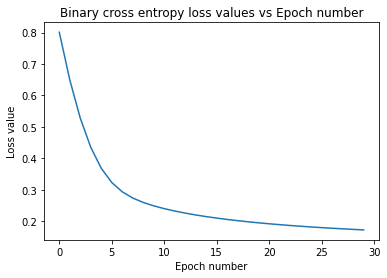

In [ ]:
eta      = 0.9
N_epochs = 30
_ = Logreg_testing(train_samples,train_labels,test_samples,test_labels,eta,N_epochs)

## Part b: 2 Dimensional data 
**Different mean vectors, same covariance matrices**

* $\mu_0 =[0,0]$ and $\mu_1 =[1,1] $ and $\Sigma_0$ = $\Sigma_1$ = Identity Matrix.
* $p_0 = 0.7, p_1 = 0.3$

### Data generation:

In [ ]:
#dimension of the data
d=2   

#mean vectors for class-0 and class-1
mu_0 = np.zeros((1,d))
mu_1 = np.ones((1,d))
mu = np.concatenate((mu_0,mu_1))

#covariance matrix of class-0 and class-1(same: Identity matrix)
covariance = [np.identity(d),np.identity(d)]

#prior probabilities for classes
p0 = 0.7
p1 = 0.3 
p = [p0, p1]

# No. of training samples and testing samples
N_train = 7000
N_test  = 3000

#generate training and testing data
train_samples,train_labels,test_samples,test_labels = generate_data(N_train,N_test,mu,covariance,p)

train-test split : 70:30

Number of training data points : 7000
Number of test data points  : 3000
Dimension of feature vectors : 2



### Perceptron:

In [ ]:
eta = 0.9
N_epochs = 30
per_cls_in,per_cls = Perceptron_testing(train_samples,train_labels,test_samples,test_labels,eta,N_epochs)

*********** PERCEPTRON *************

train-test split : 70:30, Learning rate : 0.9, Number of epochs : 30

Using classifier built from scratch
Train accuracy= 78.11 %
Test accuracy = 76.53%


### FLDA:

In [ ]:
fld_cls = FLD_testing(train_samples,train_labels,test_samples,test_labels)

*********** FLD *************

train-test split : 70:30

Using classifier built from scratch
Train accuracy= 72.30 %
Test accuracy = 71.97%


### Linear regression:

In [ ]:
linreg_cls_in,linreg_cls = Linreg_testing(train_samples,train_labels,test_samples,test_labels)

*********** LINEAR REGRESSION *************

train-test split : 70:30

Using IN-BUILT classifier
Train accuracy= 80.60 %
Test accuracy = 79.77 %
Using classifier built from scratch
Train accuracy= 80.60 %
Test accuracy = 79.77 %


### Logistic regression:

*********** LOGISTIC REGRESSION *************

train-test split : 70:30, Learning rate : 0.9, Number of epochs : 30

Using IN-BUILT classifier
Train accuracy= 80.71 %
Test accuracy = 79.50 %
Using classifier built from scratch
Train accuracy= 80.73 %
Test accuracy = 79.43 %


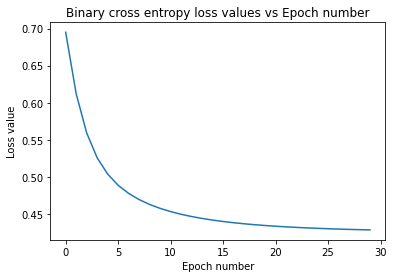

In [ ]:
eta      = 0.9
N_epochs = 30
logreg_cls_in,logreg_cls = Logreg_testing(train_samples,train_labels,test_samples,test_labels,eta,N_epochs)

### Plotting results:

<IPython.core.display.Javascript object>

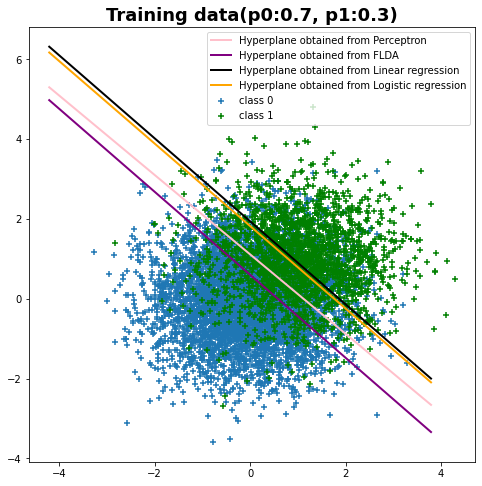

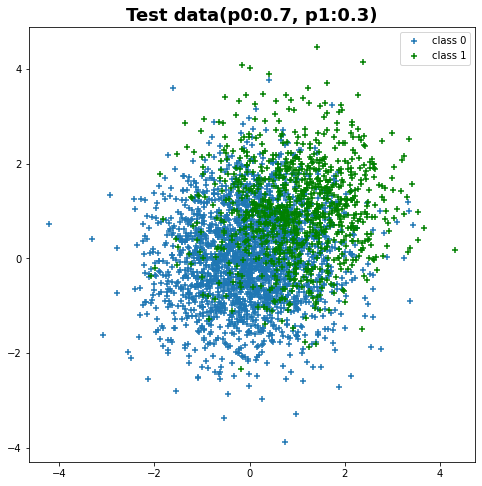

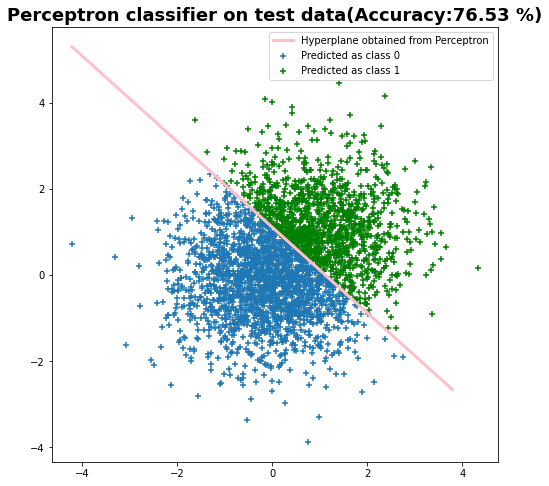

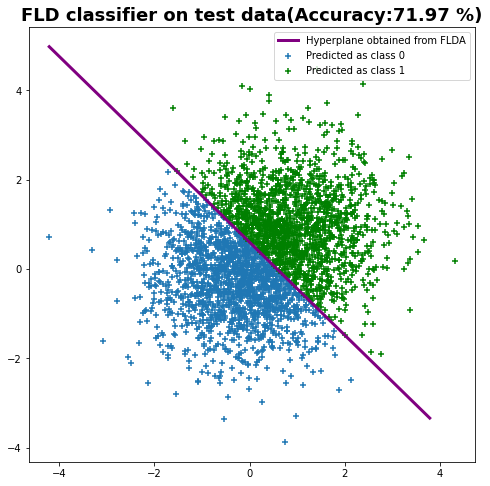

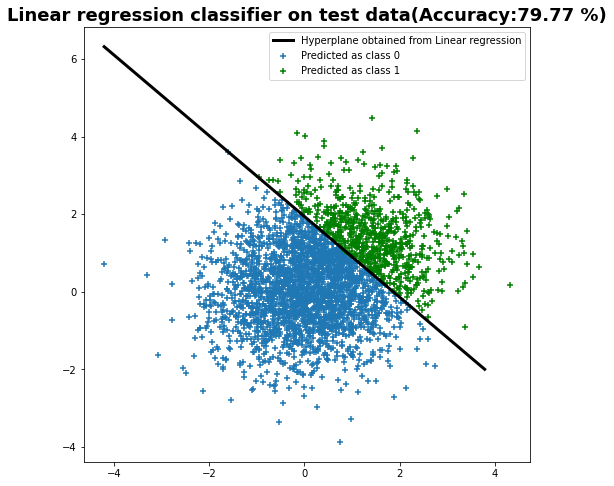

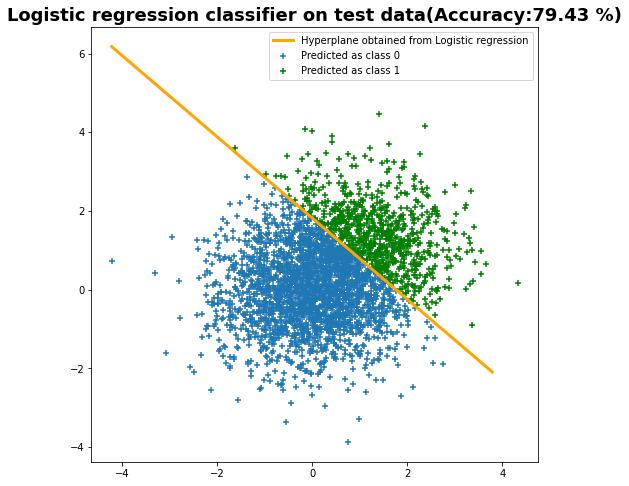

In [ ]:
plot_res(per_cls,fld_cls,linreg_cls,logreg_cls,per_cls_in,linreg_cls_in,logreg_cls_in,train_samples,train_labels,test_samples,test_labels)

## Part c: Linearly non separable data
**Same mean vectors, different covariance matrices**
* $\mu_0 =[0,0]$ and $\mu_1 =[1,1] $ and $\Sigma_0$ = Identity Matrix,
$\Sigma_1 = [1,0.9;0.9,1]$,
.
* $p_0 = 0.5, p_1 = 0.5$

### Data generation:

In [ ]:
#mean vectors for class-0 and class-1(same: zero mean vector)
mu = np.concatenate((np.ones((1,d)),np.ones((1,d))))

#covariance matrix of class-0 and class-1
cov_0 = np.identity(d)
cov_1 = np.array([[1,0.9],[0.9,1]])
covariance = [cov_0,cov_1]

#prior probabilities for classes
p0 = 0.5
p1 = 0.5 
p = [p0, p1]

# No. of training samples and testing samples
N_train = 7000
N_test  = 3000

#generate training and testing data
train_samples,train_labels,test_samples,test_labels = generate_data(N_train,N_test,mu,covariance,p)

#Transform generated d dimensional data to higher dimension where it can be linearly separable
#Transforming the data to higher dimension using polynomial transformation
poly = PolynomialFeatures(2, include_bias= 1)

train_samples_tr = poly.fit_transform(train_samples)
test_samples_tr  = poly.fit_transform(test_samples) 
print(f"Dimension of transformed feature vectors : {np.shape(train_samples_tr)[1]}")

train-test split : 70:30

Number of training data points : 7000
Number of test data points  : 3000
Dimension of feature vectors : 2

Dimension of transformed feature vectors : 6


### Perceptron:

In [ ]:
eta = 0.9
N_epochs = 30
per_cls_in,per_cls = Perceptron_testing(train_samples,train_labels,test_samples,test_labels,eta,N_epochs)
# Perceptron on transformed data
print("\nPerceptron on transformed data\n")
per_cls_in_tr,per_cls_tr = Perceptron_testing(train_samples_tr,train_labels,test_samples_tr,test_labels,eta,N_epochs)

*********** PERCEPTRON *************

train-test split : 70:30, Learning rate : 0.9, Number of epochs : 30

Using classifier built from scratch
Train accuracy= 52.37 %
Test accuracy = 51.23%

Perceptron on transformed data

*********** PERCEPTRON *************

train-test split : 70:30, Learning rate : 0.9, Number of epochs : 30

Using classifier built from scratch
Train accuracy= 58.67 %
Test accuracy = 57.93%


### FLDA:

In [ ]:
fld_cls = FLD_testing(train_samples,train_labels,test_samples,test_labels)
# FLDA on transformed data
print("\nFLDA on transformed data\n")
fld_cls_tr = FLD_testing(train_samples_tr,train_labels,test_samples_tr,test_labels)

*********** FLD *************

train-test split : 70:30

Using classifier built from scratch
Train accuracy= 50.71 %
Test accuracy = 49.77%

FLDA on transformed data

*********** FLD *************

train-test split : 70:30

Using classifier built from scratch
Train accuracy= 73.93 %
Test accuracy = 73.60%


### Linear regression:

In [ ]:
linreg_cls_in,linreg_cls = Linreg_testing(train_samples,train_labels,test_samples,test_labels)
# Linear regression on transformed data
print("\nLinear regression on transformed data\n")
linreg_cls_in_tr,linreg_cls_tr = Linreg_testing(train_samples_tr,train_labels,test_samples_tr,test_labels)

*********** LINEAR REGRESSION *************

train-test split : 70:30

Using IN-BUILT classifier
Train accuracy= 51.91 %
Test accuracy = 50.80 %
Using classifier built from scratch
Train accuracy= 51.91 %
Test accuracy = 50.80 %

Linear regression on transformed data

*********** LINEAR REGRESSION *************

train-test split : 70:30

Using IN-BUILT classifier
Train accuracy= 73.89 %
Test accuracy = 73.43 %
Using classifier built from scratch
Train accuracy= 73.89 %
Test accuracy = 73.43 %


### Logistic regression:

In [ ]:
eta      = 0.9
N_epochs = 30
logreg_cls_in,logreg_cls = Logreg_testing(train_samples,train_labels,test_samples,test_labels,eta,N_epochs,False)
# Logistic regression on transformed data
print("\nLogistic regression on transformed data\n")
logreg_cls_in_tr,logreg_cls_tr = Logreg_testing(train_samples_tr,train_labels,test_samples_tr,test_labels,eta,N_epochs,False)

*********** LOGISTIC REGRESSION *************

train-test split : 70:30, Learning rate : 0.9, Number of epochs : 30

Using IN-BUILT classifier
Train accuracy= 51.90 %
Test accuracy = 50.77 %
Using classifier built from scratch
Train accuracy= 55.19 %
Test accuracy = 55.10 %

Logistic regression on transformed data

*********** LOGISTIC REGRESSION *************

train-test split : 70:30, Learning rate : 0.9, Number of epochs : 30

Using IN-BUILT classifier
Train accuracy= 76.03 %
Test accuracy = 74.80 %
Using classifier built from scratch
Train accuracy= 65.56 %
Test accuracy = 64.07 %


### Plotting results:

<IPython.core.display.Javascript object>

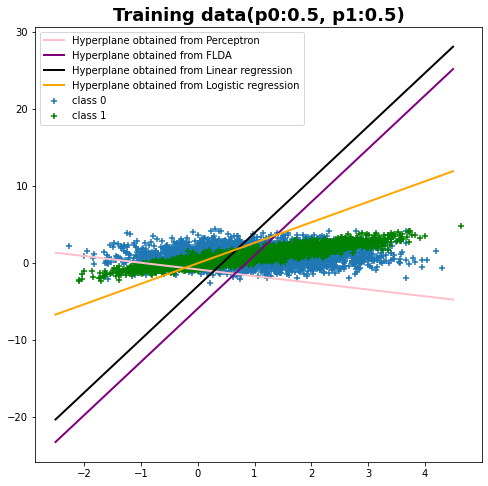

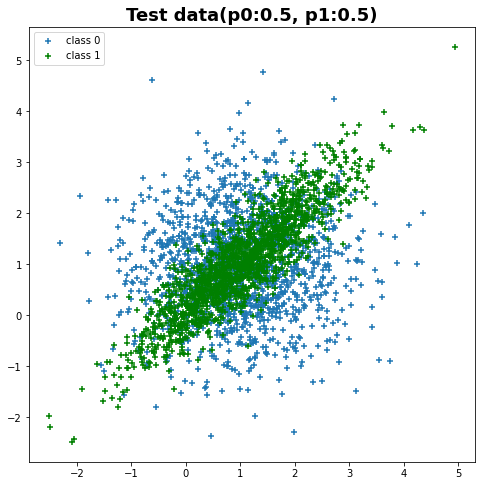

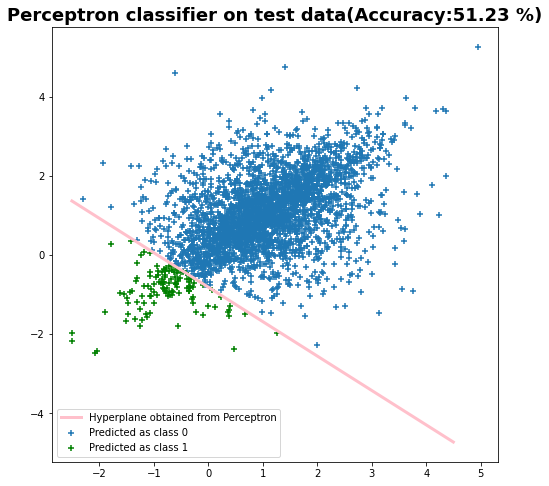

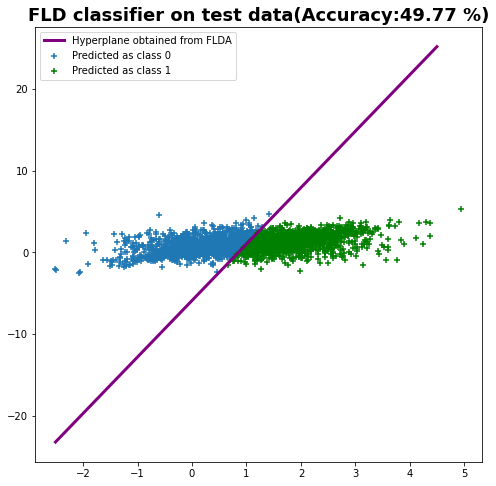

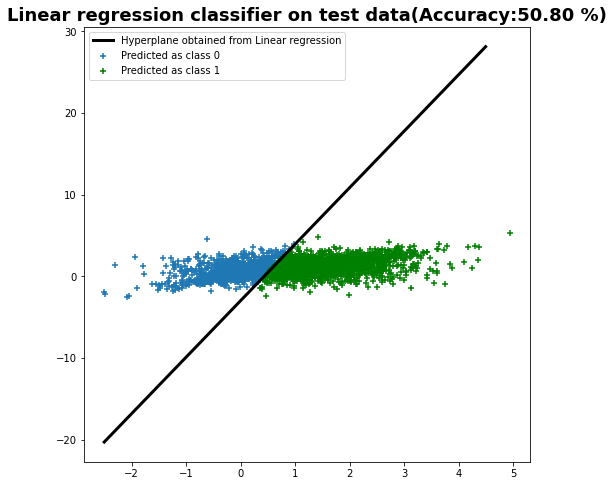

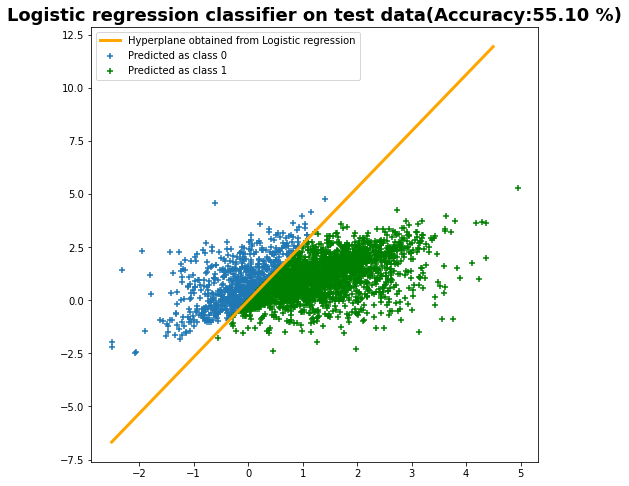

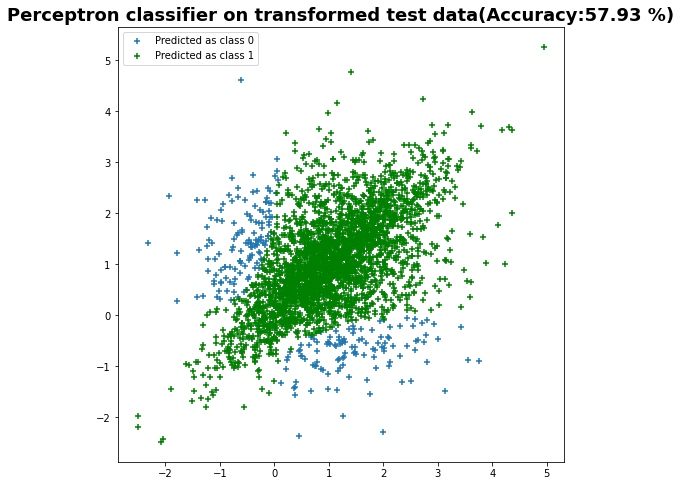

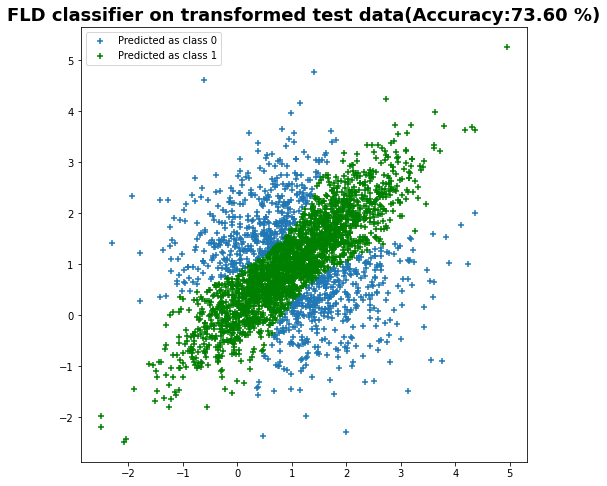

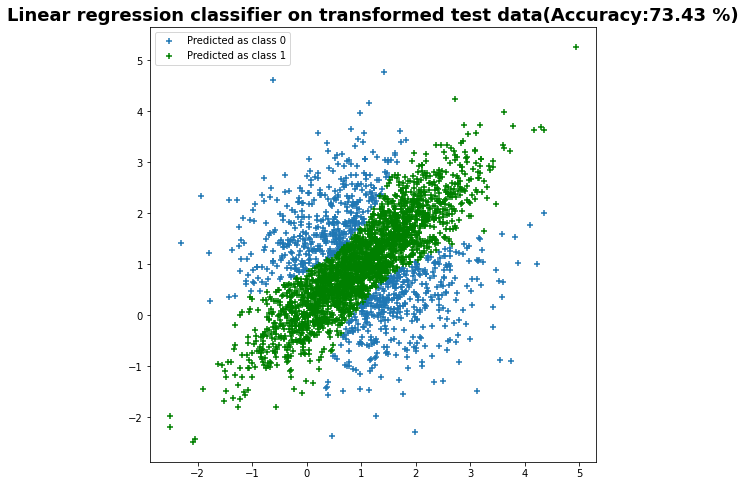

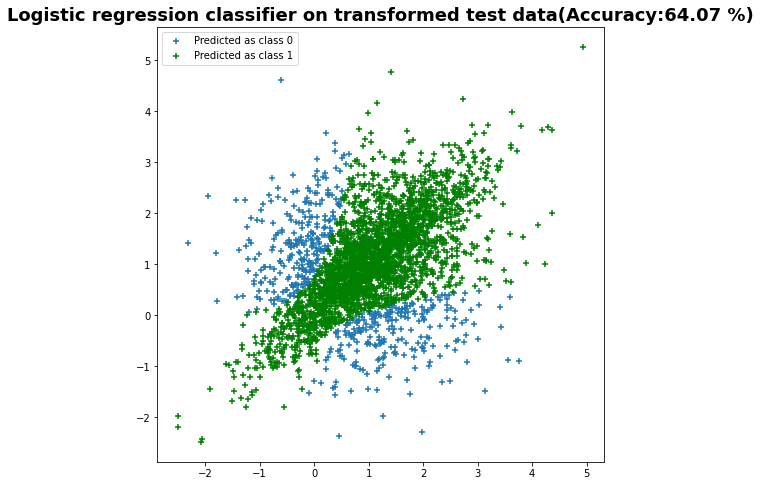

In [ ]:
plot_res(per_cls,fld_cls,linreg_cls,logreg_cls,per_cls_in,linreg_cls_in,logreg_cls_in,train_samples,train_labels,test_samples,test_labels)
# Plot of classification on transformed data

ntest_labels  = 2*test_labels - 1
# Perceptron on transformed test samples
y_pred          = per_cls_tr.predict(test_samples_tr)
pred_test_cls_0 = test_samples[np.where(y_pred == -1)[0],:] # Predicted class 0 samples in transformed test data
pred_test_cls_1 = test_samples[np.where(y_pred == 1)[0],:]  # Predicted class 1 samples in transformed test data

plt.figure(figsize=(8,8))
plt.scatter(pred_test_cls_0[:,0],pred_test_cls_0[:,1], marker='+',label = 'Predicted as class 0')
plt.scatter(pred_test_cls_1[:,0],pred_test_cls_1[:,1], c= 'green', marker='+',label = 'Predicted as class 1')
# Computing the accuracy of the estimated weight vector
test_accuracy_per  = per_cls_tr.Accuracy(test_samples_tr,ntest_labels)
plt.title("Perceptron classifier on transformed test data(Accuracy:{:.2f} %)".format(test_accuracy_per),fontsize=18, fontweight='bold')
plt.legend()
plt.show()

# FLDA on transformed test samples
y_pred          = fld_cls_tr.predict(test_samples_tr)
pred_test_cls_0 = test_samples[np.where(y_pred == 0)[0],:] # Predicted class 0 samples in transformed test data
pred_test_cls_1 = test_samples[np.where(y_pred == 1)[0],:] # Predicted class 1 samples in transformed test data

plt.figure(figsize=(8,8))
plt.scatter(pred_test_cls_0[:,0],pred_test_cls_0[:,1], marker='+',label = 'Predicted as class 0')
plt.scatter(pred_test_cls_1[:,0],pred_test_cls_1[:,1], c= 'green', marker='+',label = 'Predicted as class 1')
# Computing the accuracy of the estimated weight vector
test_accuracy_fld  = fld_cls_tr.Accuracy(test_samples_tr,test_labels)
plt.title("FLD classifier on transformed test data(Accuracy:{:.2f} %)".format(test_accuracy_fld),fontsize=18, fontweight='bold')
plt.legend()
plt.show()

# Linear regression on transformed test samples
y_pred          = linreg_cls_tr.predict(test_samples_tr)
pred_test_cls_0 = test_samples[np.where(y_pred == -1)[0],:] # Predicted class 0 samples in transformed test data
pred_test_cls_1 = test_samples[np.where(y_pred == 1)[0],:]  # Predicted class 1 samples in transformed test data

plt.figure(figsize=(8,8))
plt.scatter(pred_test_cls_0[:,0],pred_test_cls_0[:,1], marker='+',label = 'Predicted as class 0')
plt.scatter(pred_test_cls_1[:,0],pred_test_cls_1[:,1], c= 'green', marker='+',label = 'Predicted as class 1')
# Computing the accuracy of the estimated weight vector
test_accuracy_linreg  = linreg_cls_tr.Accuracy(test_samples_tr,ntest_labels)
plt.title("Linear regression classifier on transformed test data(Accuracy:{:.2f} %)".format(test_accuracy_linreg),fontsize=18, fontweight='bold')
plt.legend()
plt.show()

# Logistic regression on transformed test samples
y_pred          = logreg_cls_tr.predict(test_samples_tr)
pred_test_cls_0 = test_samples[np.where(y_pred == 0)[0],:] # Predicted class 0 samples in transformed test data
pred_test_cls_1 = test_samples[np.where(y_pred == 1)[0],:] # Predicted class 1 samples in transformed test data

plt.figure(figsize=(8,8))
plt.scatter(pred_test_cls_0[:,0],pred_test_cls_0[:,1], marker='+',label = 'Predicted as class 0')
plt.scatter(pred_test_cls_1[:,0],pred_test_cls_1[:,1], c= 'green', marker='+',label = 'Predicted as class 1')
# Computing the accuracy of the estimated weight vector
test_accuracy_logreg  = logreg_cls_tr.Accuracy(test_samples_tr,test_labels)
plt.title("Logistic regression classifier on transformed test data(Accuracy:{:.2f} %)".format(test_accuracy_logreg),fontsize=18, fontweight='bold')
plt.legend()
plt.show()

## Part d:
**Different mean vectors & different covariance matrices**
* $\mu_0 =[3,6]$ and $\mu_1 =[3,-2] $ and $\Sigma_0 = [0.5,0;0,2]$,
$\Sigma_1 = [2,0;0,2]$.
* $p_0 = 0.8, p_1 = 0.2$

### Data generation:

In [ ]:
#mean vectors for class-0 and class-1(same: zero mean vector)
mu_0 = np.array([[3],[6]])
mu_1 = np.array([[3],[-2]])
mu   = np.concatenate((mu_0.T,mu_1.T))

#covariance matrix of class-0 and class-1
cov_0 = np.array([[0.5,0],[0,2]])
cov_1 = np.array([[2,0],[0,2]])
covariance = [cov_0,cov_1]

#prior probabilities for classes
p0 = 0.8
p1 = 0.2 
p = [p0, p1]

# No. of training samples and testing samples
N_train = 7000
N_test  = 3000

#generate training and testing data
train_samples,train_labels,test_samples,test_labels = generate_data(N_train,N_test,mu,covariance,p)

train-test split : 70:30

Number of training data points : 7000
Number of test data points  : 3000
Dimension of feature vectors : 2



### Perceptron:

In [ ]:
eta = 0.9
N_epochs = 30
per_cls_in,per_cls = Perceptron_testing(train_samples,train_labels,test_samples,test_labels,eta,N_epochs)

*********** PERCEPTRON *************

train-test split : 70:30, Learning rate : 0.9, Number of epochs : 30

Using classifier built from scratch
Train accuracy= 99.04 %
Test accuracy = 99.00%


### FLDA:


In [ ]:
fld_cls = FLD_testing(train_samples,train_labels,test_samples,test_labels)

*********** FLD *************

train-test split : 70:30

Using classifier built from scratch
Train accuracy= 90.60 %
Test accuracy = 90.23%


### Linear regression:

In [ ]:
linreg_cls_in,linreg_cls = Linreg_testing(train_samples,train_labels,test_samples,test_labels)

*********** LINEAR REGRESSION *************

train-test split : 70:30

Using IN-BUILT classifier
Train accuracy= 99.80 %
Test accuracy = 99.77 %
Using classifier built from scratch
Train accuracy= 99.80 %
Test accuracy = 99.77 %


### Logistic regression:

*********** LOGISTIC REGRESSION *************

train-test split : 70:30, Learning rate : 0.9, Number of epochs : 30

Using IN-BUILT classifier
Train accuracy= 99.80 %
Test accuracy = 99.73 %
Using classifier built from scratch
Train accuracy= 99.11 %
Test accuracy = 99.17 %


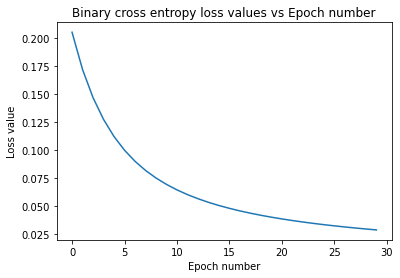

In [ ]:
eta      = 0.9
N_epochs = 30
logreg_cls_in,logreg_cls = Logreg_testing(train_samples,train_labels,test_samples,test_labels,eta,N_epochs)

### Plotting results:

<IPython.core.display.Javascript object>

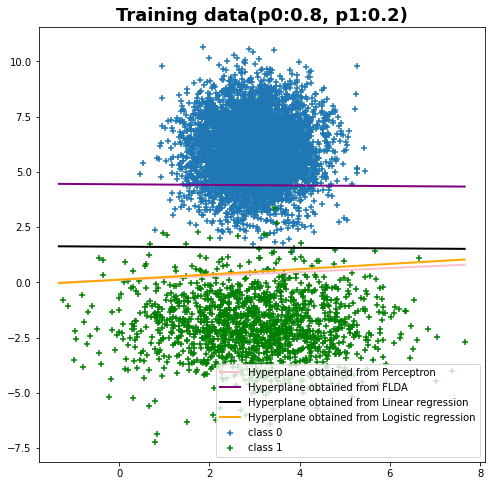

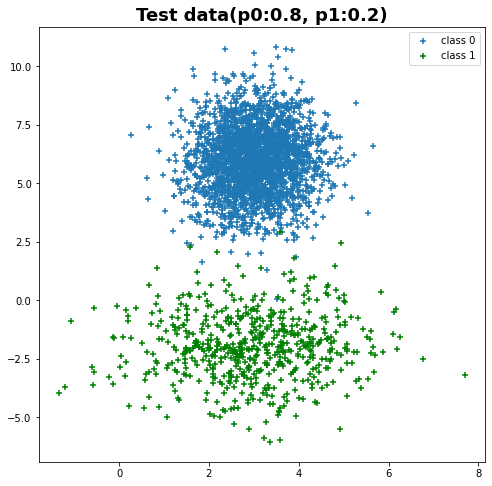

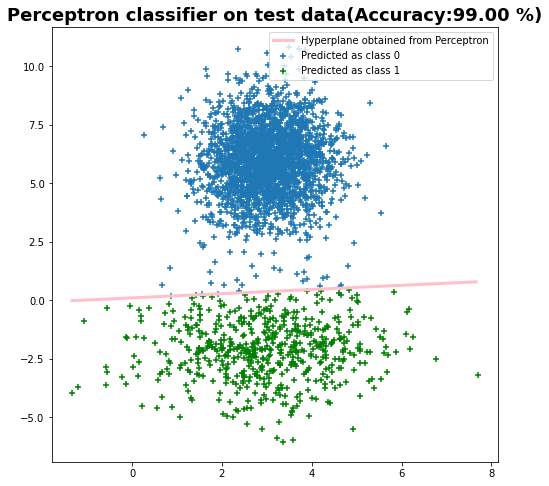

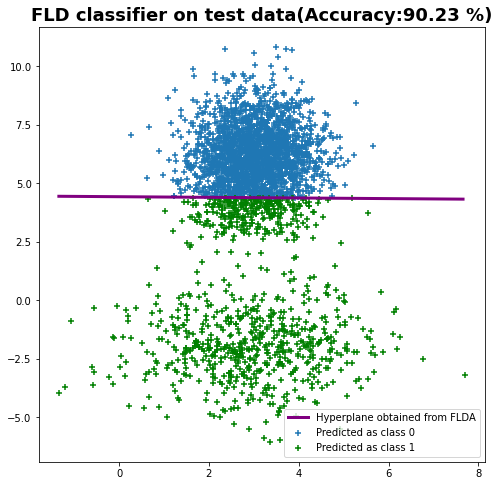

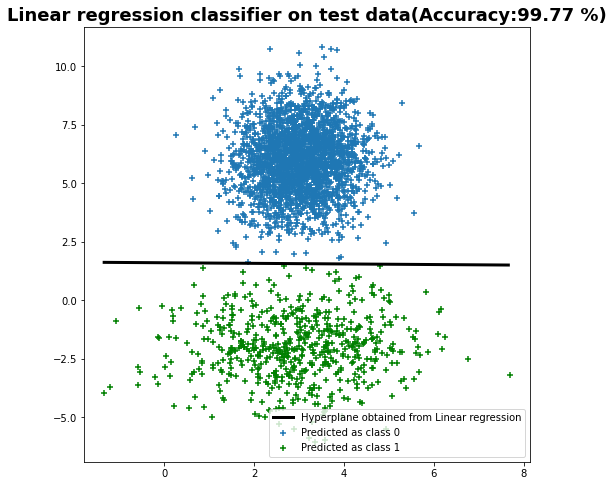

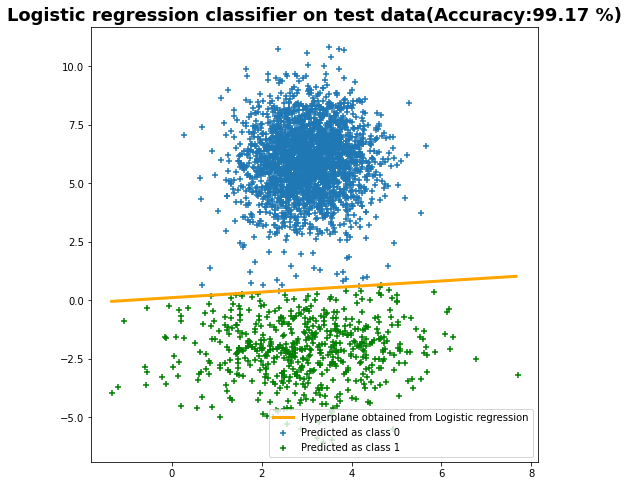

In [ ]:
plot_res(per_cls,fld_cls,linreg_cls,logreg_cls,per_cls_in,linreg_cls_in,logreg_cls_in,train_samples,train_labels,test_samples,test_labels)

# Problem 2: German credit card data

## Data generation:

In [155]:
testdata_per = 0.2
train_samples,train_labels,test_samples,test_labels = German_data_numeric_preprocessing(testdata_per)
testdata_per_1 = 0.3
train_samples_1,train_labels_1,test_samples_1,test_labels_1 = German_data_numeric_preprocessing(testdata_per_1)

class probabilities: p0 = 0.3,p1 = 0.7
For train-test split : 80:20

Number of training data points : 800
Number of test data points  : 200
Dimension of feature vectors : 20

class probabilities: p0 = 0.3,p1 = 0.7
For train-test split : 70:30

Number of training data points : 700
Number of test data points  : 300
Dimension of feature vectors : 20



## Perceptron:

<IPython.core.display.Javascript object>

*********** PERCEPTRON *************

train-test split : 80:20, Learning rate : 0.9, Number of epochs : 30

Using classifier built from scratch
Train accuracy= 68.50 %
Test accuracy = 62.00%
f1_score : 0.6171855010660979



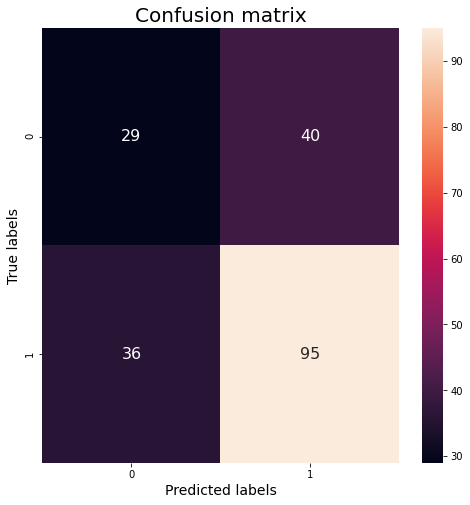

*********** PERCEPTRON *************

train-test split : 70:30, Learning rate : 0.9, Number of epochs : 30

Using classifier built from scratch
Train accuracy= 67.71 %
Test accuracy = 71.67%
f1_score : 0.7149950244532793



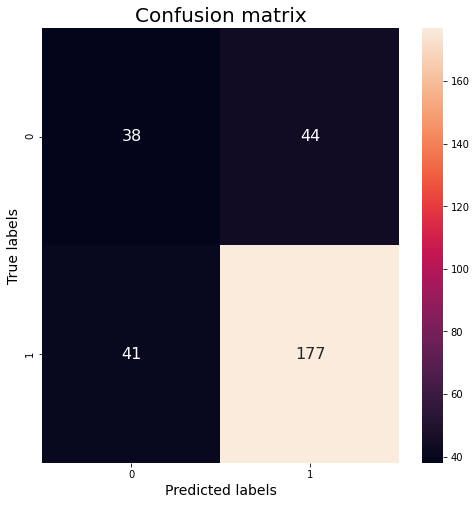

In [ ]:
eta = 0.9
N_epochs = 30
avoid_scroll_output_window()
_,per_cls = Perceptron_testing(train_samples,train_labels,test_samples,test_labels,eta,N_epochs)

y_pred       = per_cls.predict(test_samples)
y_pred[y_pred == -1] = 0
f1_score_per = f1_score(test_labels,y_pred,average = 'weighted')
print(f"f1_score : {f1_score_per}\n")

conf_mat = confusion_matrix(test_labels,y_pred)
fig= plt.figure(figsize=(8,8))
sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
plt.xlabel("Predicted labels",fontsize=14)
plt.ylabel("True labels",fontsize=14)
plt.title("Confusion matrix",fontsize=20)
plt.show()

_,per_cls = Perceptron_testing(train_samples_1,train_labels_1,test_samples_1,test_labels_1,eta,N_epochs)

y_pred       = per_cls.predict(test_samples_1)
y_pred[y_pred == -1] = 0
f1_score_per = f1_score(test_labels_1,y_pred,average = 'weighted')
print(f"f1_score : {f1_score_per}\n")

conf_mat = confusion_matrix(test_labels_1,y_pred)
fig= plt.figure(figsize=(8,8))
sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
plt.xlabel("Predicted labels",fontsize=14)
plt.ylabel("True labels",fontsize=14)
plt.title("Confusion matrix",fontsize=20)
plt.show()

### FLDA: 

<IPython.core.display.Javascript object>

*********** FLD *************

train-test split : 80:20

Using classifier built from scratch
Train accuracy= 69.88 %
Test accuracy = 69.00%
f1_score : 0.6973787000305158



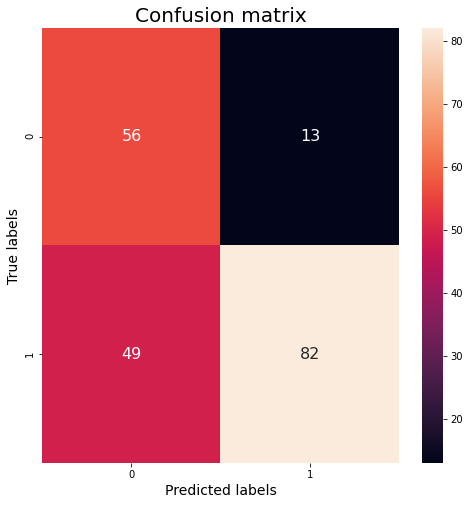

*********** FLD *************

train-test split : 70:30

Using classifier built from scratch
Train accuracy= 69.43 %
Test accuracy = 68.00%
f1_score : 0.6971483253588516



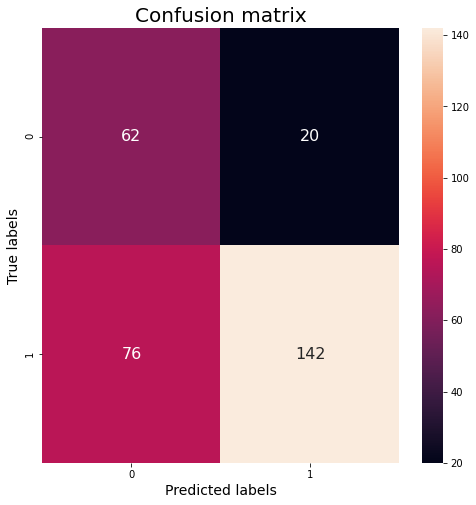

In [ ]:
avoid_scroll_output_window()
fld_cls = FLD_testing(train_samples,train_labels,test_samples,test_labels)

y_pred       = fld_cls.predict(test_samples)
f1_score_fld = f1_score(test_labels,y_pred,average = 'weighted')
print(f"f1_score : {f1_score_fld}\n")

conf_mat = confusion_matrix(test_labels,y_pred)
fig= plt.figure(figsize=(8,8))
sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
plt.xlabel("Predicted labels",fontsize=14)
plt.ylabel("True labels",fontsize=14)
plt.title("Confusion matrix",fontsize=20)
plt.show()

fld_cls = FLD_testing(train_samples_1,train_labels_1,test_samples_1,test_labels_1)

y_pred       = fld_cls.predict(test_samples_1)
f1_score_fld = f1_score(test_labels_1,y_pred,average = 'weighted')
print(f"f1_score : {f1_score_fld}\n")

conf_mat = confusion_matrix(test_labels_1,y_pred)
fig= plt.figure(figsize=(8,8))
sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
plt.xlabel("Predicted labels",fontsize=14)
plt.ylabel("True labels",fontsize=14)
plt.title("Confusion matrix",fontsize=20)
plt.show()

## Linear regression:

<IPython.core.display.Javascript object>

*********** LINEAR REGRESSION *************

train-test split : 80:20

Using IN-BUILT classifier
Train accuracy= 77.12 %
Test accuracy = 74.50 %
Using classifier built from scratch
Train accuracy= 77.12 %
Test accuracy = 74.50 %
f1_score : 0.7140696711811652



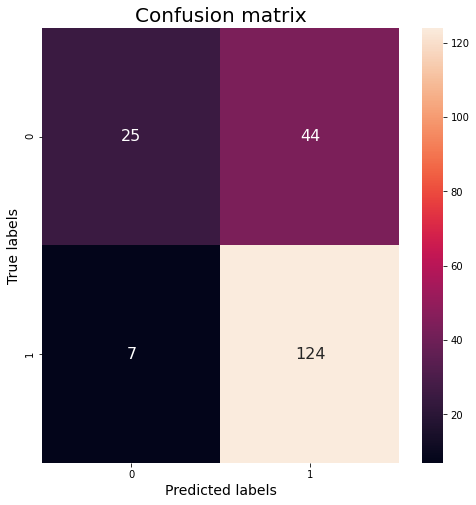

*********** LINEAR REGRESSION *************

train-test split : 70:30

Using IN-BUILT classifier
Train accuracy= 75.86 %
Test accuracy = 76.00 %
Using classifier built from scratch
Train accuracy= 75.86 %
Test accuracy = 76.00 %
f1_score : 0.7485964912280701



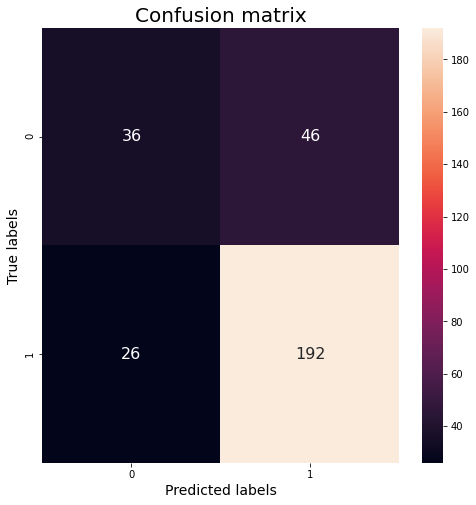

In [ ]:
avoid_scroll_output_window()
_,linreg_cls = Linreg_testing(train_samples,train_labels,test_samples,test_labels)

y_pred       = linreg_cls.predict(test_samples)
y_pred[y_pred == -1] = 0
f1_score_lin = f1_score(test_labels,y_pred,average = 'weighted')
print(f"f1_score : {f1_score_lin}\n")

conf_mat = confusion_matrix(test_labels,y_pred)
fig= plt.figure(figsize=(8,8))
sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
plt.xlabel("Predicted labels",fontsize=14)
plt.ylabel("True labels",fontsize=14)
plt.title("Confusion matrix",fontsize=20)
plt.show()

_,linreg_cls = Linreg_testing(train_samples_1,train_labels_1,test_samples_1,test_labels_1)

y_pred       = linreg_cls.predict(test_samples_1)
y_pred[y_pred == -1] = 0
f1_score_lin = f1_score(test_labels_1,y_pred,average = 'weighted')
print(f"f1_score : {f1_score_lin}\n")

conf_mat = confusion_matrix(test_labels_1,y_pred)
fig= plt.figure(figsize=(8,8))
sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
plt.xlabel("Predicted labels",fontsize=14)
plt.ylabel("True labels",fontsize=14)
plt.title("Confusion matrix",fontsize=20)
plt.show()

## Logistic regression: 

<IPython.core.display.Javascript object>

*********** LOGISTIC REGRESSION *************

train-test split : 80:20, Learning rate : 0.9, Number of epochs : 30

Using IN-BUILT classifier
Train accuracy= 76.62 %
Test accuracy = 74.50 %
Using classifier built from scratch
Train accuracy= 76.88 %
Test accuracy = 76.50 %
f1_score : 0.738919616880782



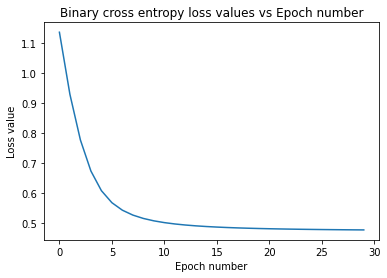

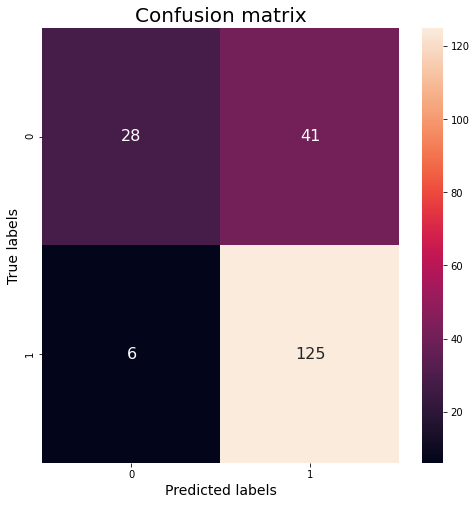

*********** LOGISTIC REGRESSION *************

train-test split : 70:30, Learning rate : 0.9, Number of epochs : 30

Using IN-BUILT classifier
Train accuracy= 76.43 %
Test accuracy = 76.33 %
Using classifier built from scratch
Train accuracy= 77.29 %
Test accuracy = 76.67 %
f1_score : 0.7594074074074073



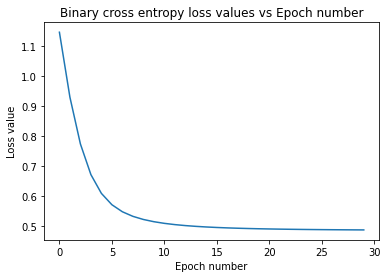

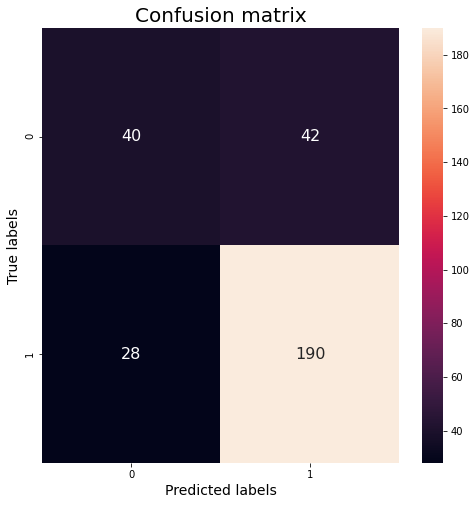

In [ ]:
eta      = 0.9
N_epochs = 30
avoid_scroll_output_window()
_,logreg_cls = Logreg_testing(train_samples,train_labels,test_samples,test_labels,eta,N_epochs)

y_pred       = logreg_cls.predict(test_samples)
f1_score_log = f1_score(test_labels,y_pred,average = 'weighted')
print(f"f1_score : {f1_score_log}\n")

conf_mat = confusion_matrix(test_labels,y_pred)
fig= plt.figure(figsize=(8,8))
sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
plt.xlabel("Predicted labels",fontsize=14)
plt.ylabel("True labels",fontsize=14)
plt.title("Confusion matrix",fontsize=20)
plt.show()

_,logreg_cls = Logreg_testing(train_samples_1,train_labels_1,test_samples_1,test_labels_1,eta,N_epochs)

y_pred       = logreg_cls.predict(test_samples_1)
f1_score_log = f1_score(test_labels_1,y_pred,average = 'weighted')
print(f"f1_score : {f1_score_log}\n")

conf_mat = confusion_matrix(test_labels_1,y_pred)
fig= plt.figure(figsize=(8,8))
sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
plt.xlabel("Predicted labels",fontsize=14)
plt.ylabel("True labels",fontsize=14)
plt.title("Confusion matrix",fontsize=20)
plt.show()

## SVM:

<IPython.core.display.Javascript object>

************ SVM *************

For train-test split : 80:20

Train accuracy= 85.62 %
Test accuracy = 75.00 %

f1_score : 0.7155358832274631



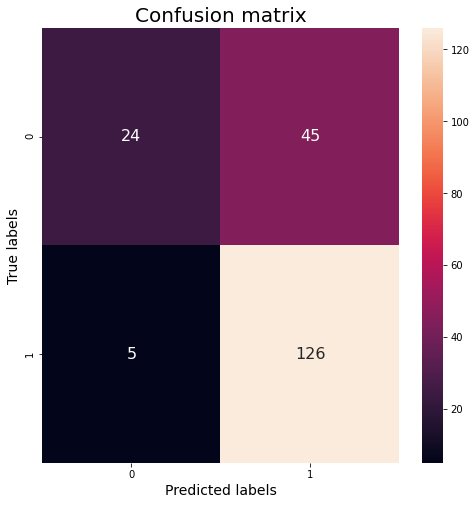

For train-test split : 70:30

Train accuracy= 84.71 %
Test accuracy = 76.67 %

f1_score : 0.748057993295326



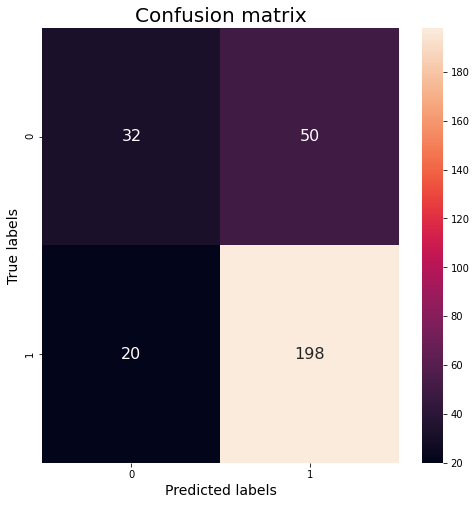

In [ ]:
avoid_scroll_output_window()
print("************ SVM *************\n")
# Create a svm Classifier
SVM_cls = svm.SVC() 

# Train the model using the training data
SVM_cls.fit(train_samples, train_labels.ravel())

# Predict the class labels for test data
y_pred_train = SVM_cls.predict(train_samples)
y_pred_test  = SVM_cls.predict(test_samples)

train_accuracy_svm = accuracy_score(train_labels,y_pred_train)*100 
test_accuracy_svm  = accuracy_score(test_labels,y_pred_test)*100 

f1_score_svm = f1_score(test_labels,y_pred_test,average = 'weighted')

print(f"For train-test split : {int((1-testdata_per)*100)}:{int(testdata_per*100)}\n")
print(f"Train accuracy= {train_accuracy_svm:.2f} %")
print(f"Test accuracy = {test_accuracy_svm:.2f} %\n")
print(f"f1_score : {f1_score_svm}\n")

conf_mat = confusion_matrix(test_labels,y_pred_test)
fig= plt.figure(figsize=(8,8))
sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
plt.xlabel("Predicted labels",fontsize=14)
plt.ylabel("True labels",fontsize=14)
plt.title("Confusion matrix",fontsize=20)
plt.show()

# Train the model using the training data
SVM_cls.fit(train_samples_1, train_labels_1.ravel())

# Predict the class labels for test data
y_pred_train_1 = SVM_cls.predict(train_samples_1)
y_pred_test_1  = SVM_cls.predict(test_samples_1)

train_accuracy_svm = accuracy_score(train_labels_1,y_pred_train_1)*100 
test_accuracy_svm  = accuracy_score(test_labels_1,y_pred_test_1)*100

f1_score_svm = f1_score(test_labels_1,y_pred_test_1,average = 'weighted')

print(f"For train-test split : {int((1-testdata_per_1)*100)}:{int(testdata_per_1*100)}\n")
print(f"Train accuracy= {train_accuracy_svm:.2f} %")
print(f"Test accuracy = {test_accuracy_svm:.2f} %\n")
print(f"f1_score : {f1_score_svm}\n")

conf_mat = confusion_matrix(test_labels_1,y_pred_test_1)
fig= plt.figure(figsize=(8,8))
sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
plt.xlabel("Predicted labels",fontsize=14)
plt.ylabel("True labels",fontsize=14)
plt.title("Confusion matrix",fontsize=20)
plt.show()

# Problem 3: Porto-Seguro safe driver prediction data

## Data generation:

In [158]:
testdata_per = 0.2
train_samples,train_labels,test_samples,test_labels = Safe_driver_prediction_preprocessing(testdata_per)

# Commented because it was taking more time to transform data to higher dimension

# #Transform generated d dimensional data to higher dimension where it can be linearly separable
# #Transforming the data to higher dimension using polynomial transformation
# poly = PolynomialFeatures(54, include_bias= 1)

# train_samples_tr = poly.fit_transform(train_samples)
# test_samples_tr  = poly.fit_transform(test_samples) 
# print(f"Dimension of transformed feature vectors : {np.shape(train_samples_tr)[1]}")

testdata_per_1 = 0.3
train_samples_1,train_labels_1,test_samples_1,test_labels_1 = Safe_driver_prediction_preprocessing(testdata_per_1)

class probabilities : p0 = 0.963552482140817,p1 = 0.036447517859182946
class probabilities after under sampling: p0 = 0.5,p1 = 0.5
For train-test split : 80:20

Number of training data points : 34710
Number of test data points  : 8678
Dimension of feature vectors : 54

class probabilities : p0 = 0.963552482140817,p1 = 0.036447517859182946
class probabilities after under sampling: p0 = 0.5,p1 = 0.5
For train-test split : 70:30

Number of training data points : 30371
Number of test data points  : 13017
Dimension of feature vectors : 54



## Perceptron:

<IPython.core.display.Javascript object>

*********** PERCEPTRON *************

train-test split : 80:21, Learning rate : 0.9, Number of epochs : 30

Using classifier built from scratch
Train accuracy= 47.61 %
Test accuracy = 46.42%
f1_score : 0.45397434852123786



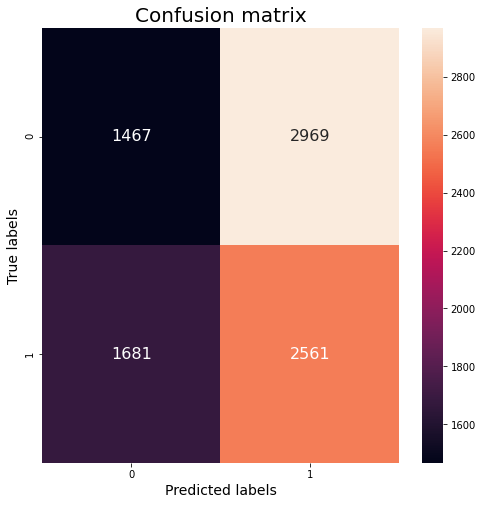

*********** PERCEPTRON *************

train-test split : 70:31, Learning rate : 0.9, Number of epochs : 30

Using classifier built from scratch
Train accuracy= 47.99 %
Test accuracy = 48.21%
f1_score : 0.4722623222910797



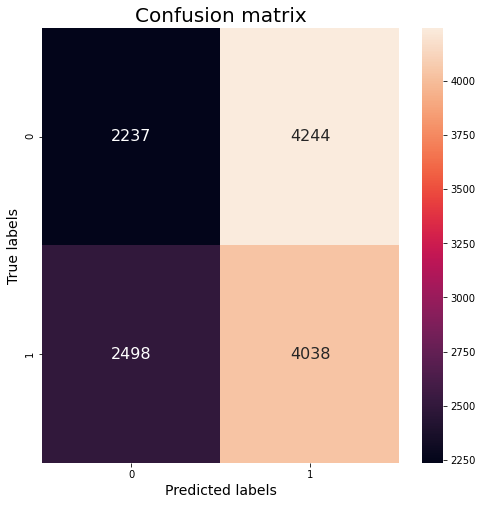

In [159]:
eta = 0.9
N_epochs = 30
avoid_scroll_output_window()
_,per_cls = Perceptron_testing(train_samples,train_labels,test_samples,test_labels,eta,N_epochs)

y_pred       = per_cls.predict(test_samples)
y_pred[y_pred == -1] = 0
f1_score_per = f1_score(test_labels,y_pred,average = 'weighted')
print(f"f1_score : {f1_score_per}\n")

conf_mat = confusion_matrix(test_labels,y_pred)
fig= plt.figure(figsize=(8,8))
sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
plt.xlabel("Predicted labels",fontsize=14)
plt.ylabel("True labels",fontsize=14)
plt.title("Confusion matrix",fontsize=20)
plt.show()

# # Perceptron on transformed data
# print("\nPerceptron on transformed data\n")
# _,per_cls_tr = Perceptron_testing(train_samples_tr,train_labels,test_samples_tr,test_labels,eta,N_epochs)

# y_pred       = per_cls_tr.predict(test_samples_tr)
# y_pred[y_pred == -1] = 0
# f1_score_per = f1_score(test_labels,y_pred,average = 'weighted')
# print(f"f1_score : {f1_score_per}\n")

# conf_mat = confusion_matrix(test_labels,y_pred)
# fig= plt.figure(figsize=(8,8))
# sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
# plt.xlabel("Predicted labels",fontsize=14)
# plt.ylabel("True labels",fontsize=14)
# plt.title("Confusion matrix",fontsize=20)
# plt.show()

_,per_cls = Perceptron_testing(train_samples_1,train_labels_1,test_samples_1,test_labels_1,eta,N_epochs)

y_pred       = per_cls.predict(test_samples_1)
y_pred[y_pred == -1] = 0
f1_score_per = f1_score(test_labels_1,y_pred,average = 'weighted')
print(f"f1_score : {f1_score_per}\n")

conf_mat = confusion_matrix(test_labels_1,y_pred)
fig= plt.figure(figsize=(8,8))
sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
plt.xlabel("Predicted labels",fontsize=14)
plt.ylabel("True labels",fontsize=14)
plt.title("Confusion matrix",fontsize=20)
plt.show()

### FLDA:

<IPython.core.display.Javascript object>

*********** FLD *************

train-test split : 80:21

Using classifier built from scratch
Train accuracy= 58.52 %
Test accuracy = 58.05%
f1_score : 0.579675336967485



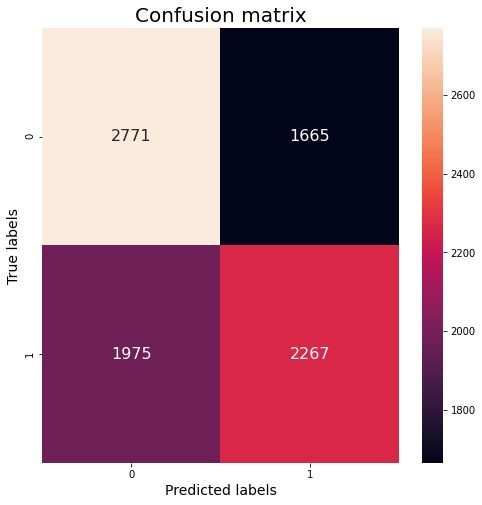

*********** FLD *************

train-test split : 70:31

Using classifier built from scratch
Train accuracy= 58.56 %
Test accuracy = 58.59%
f1_score : 0.5853535935477001



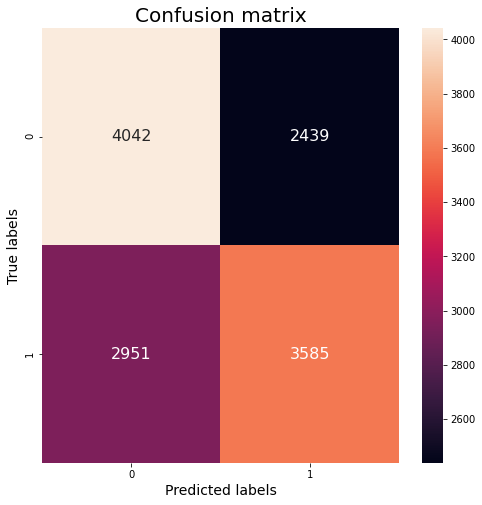

In [160]:
avoid_scroll_output_window()
fld_cls = FLD_testing(train_samples,train_labels,test_samples,test_labels)

y_pred       = fld_cls.predict(test_samples)
f1_score_fld = f1_score(test_labels,y_pred,average = 'weighted')
print(f"f1_score : {f1_score_fld}\n")

conf_mat = confusion_matrix(test_labels,y_pred)
fig= plt.figure(figsize=(8,8))
sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
plt.xlabel("Predicted labels",fontsize=14)
plt.ylabel("True labels",fontsize=14)
plt.title("Confusion matrix",fontsize=20)
plt.show()

# # FLDA on transformed data
# print("\nFLDA on transformed data\n")
# fld_cls_tr = FLD_testing(train_samples_tr,train_labels,test_samples_tr,test_labels)

# y_pred       = fld_cls_tr.predict(test_samples_tr)
# f1_score_fld = f1_score(test_labels,y_pred,average = 'weighted')
# print(f"f1_score : {f1_score_fld}\n")

# conf_mat = confusion_matrix(test_labels,y_pred)
# fig= plt.figure(figsize=(8,8))
# sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
# plt.xlabel("Predicted labels",fontsize=14)
# plt.ylabel("True labels",fontsize=14)
# plt.title("Confusion matrix",fontsize=20)
# plt.show()

fld_cls = FLD_testing(train_samples_1,train_labels_1,test_samples_1,test_labels_1)

y_pred       = fld_cls.predict(test_samples_1)
f1_score_fld = f1_score(test_labels_1,y_pred,average = 'weighted')
print(f"f1_score : {f1_score_fld}\n")

conf_mat = confusion_matrix(test_labels_1,y_pred)
fig= plt.figure(figsize=(8,8))
sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
plt.xlabel("Predicted labels",fontsize=14)
plt.ylabel("True labels",fontsize=14)
plt.title("Confusion matrix",fontsize=20)
plt.show()

## Linear regression:

<IPython.core.display.Javascript object>

*********** LINEAR REGRESSION *************

train-test split : 80:21

Using IN-BUILT classifier
Train accuracy= 58.59 %
Test accuracy = 58.14 %
Using classifier built from scratch
Train accuracy= 58.61 %
Test accuracy = 58.10 %
f1_score : 0.5805086095885221



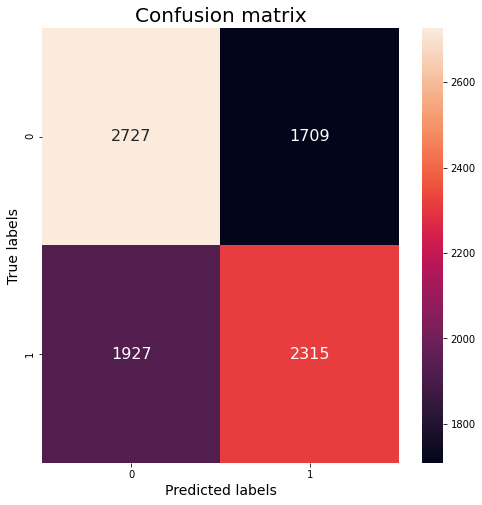

*********** LINEAR REGRESSION *************

train-test split : 70:31

Using IN-BUILT classifier
Train accuracy= 58.54 %
Test accuracy = 58.50 %
Using classifier built from scratch
Train accuracy= 58.55 %
Test accuracy = 58.51 %
f1_score : 0.5843953279452863



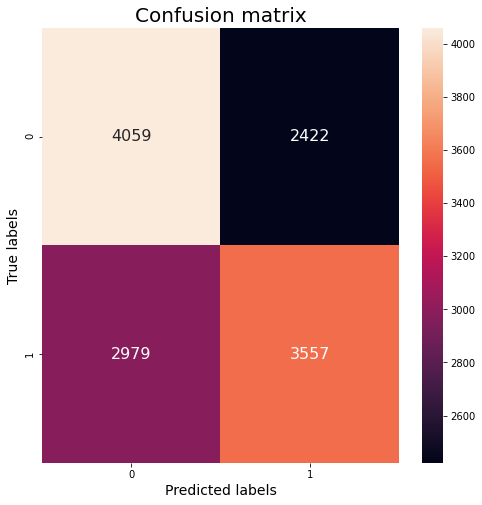

In [161]:
avoid_scroll_output_window()
_,linreg_cls = Linreg_testing(train_samples,train_labels,test_samples,test_labels)

y_pred       = linreg_cls.predict(test_samples)
y_pred[y_pred == -1] = 0
f1_score_lin = f1_score(test_labels,y_pred,average = 'weighted')
print(f"f1_score : {f1_score_lin}\n")

conf_mat = confusion_matrix(test_labels,y_pred)
fig= plt.figure(figsize=(8,8))
sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
plt.xlabel("Predicted labels",fontsize=14)
plt.ylabel("True labels",fontsize=14)
plt.title("Confusion matrix",fontsize=20)
plt.show()

# # Linear regression on transformed data
# print("\nLinear regression on transformed data\n")
# _,linreg_cls_tr = Linreg_testing(train_samples_tr,train_labels,test_samples_tr,test_labels)

# y_pred       = linreg_cls_tr.predict(test_samples_tr)
# y_pred[y_pred == -1] = 0
# f1_score_lin = f1_score(test_labels,y_pred,average = 'weighted')
# print(f"f1_score : {f1_score_lin}\n")

# conf_mat = confusion_matrix(test_labels,y_pred)
# fig= plt.figure(figsize=(8,8))
# sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
# plt.xlabel("Predicted labels",fontsize=14)
# plt.ylabel("True labels",fontsize=14)
# plt.title("Confusion matrix",fontsize=20)
# plt.show()

_,linreg_cls = Linreg_testing(train_samples_1,train_labels_1,test_samples_1,test_labels_1)

y_pred       = linreg_cls.predict(test_samples_1)
y_pred[y_pred == -1] = 0
f1_score_lin = f1_score(test_labels_1,y_pred,average = 'weighted')
print(f"f1_score : {f1_score_lin}\n")

conf_mat = confusion_matrix(test_labels_1,y_pred)
fig= plt.figure(figsize=(8,8))
sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
plt.xlabel("Predicted labels",fontsize=14)
plt.ylabel("True labels",fontsize=14)
plt.title("Confusion matrix",fontsize=20)
plt.show()

## Logistic regression:

<IPython.core.display.Javascript object>

*********** LOGISTIC REGRESSION *************

train-test split : 80:21, Learning rate : 0.9, Number of epochs : 30

Using IN-BUILT classifier
Train accuracy= 58.60 %
Test accuracy = 58.15 %
Using classifier built from scratch
Train accuracy= 57.97 %
Test accuracy = 57.73 %
f1_score : 0.5771523081255794



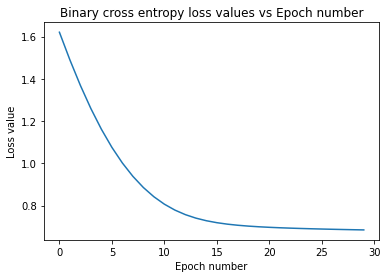

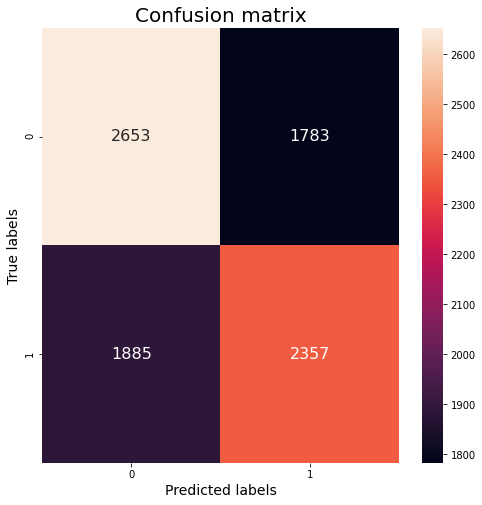

*********** LOGISTIC REGRESSION *************

train-test split : 70:31, Learning rate : 0.9, Number of epochs : 30

Using IN-BUILT classifier
Train accuracy= 58.55 %
Test accuracy = 58.59 %
Using classifier built from scratch
Train accuracy= 57.80 %
Test accuracy = 58.05 %
f1_score : 0.5802800707162671



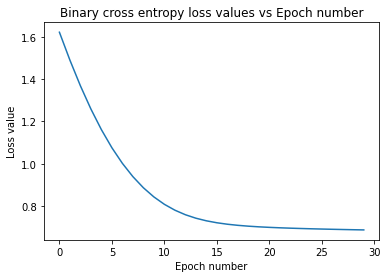

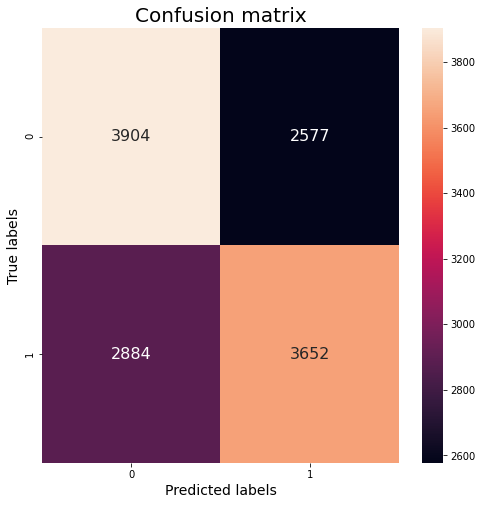

In [163]:
eta      = 0.9
N_epochs = 30
avoid_scroll_output_window()
_,logreg_cls = Logreg_testing(train_samples,train_labels,test_samples,test_labels,eta,N_epochs)

y_pred       = logreg_cls.predict(test_samples)
f1_score_log = f1_score(test_labels,y_pred,average = 'weighted')
print(f"f1_score : {f1_score_log}\n")

conf_mat = confusion_matrix(test_labels,y_pred)
fig= plt.figure(figsize=(8,8))
sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
plt.xlabel("Predicted labels",fontsize=14)
plt.ylabel("True labels",fontsize=14)
plt.title("Confusion matrix",fontsize=20)
plt.show()

# # Logistic regression on transformed data
# print("\nLogistic regression on transformed data\n")
# _,logreg_cls_tr = Logreg_testing(train_samples_tr,train_labels,test_samples_tr,test_labels,eta,N_epochs,False)

# y_pred       = logreg_cls_tr.predict(test_samples_tr)
# f1_score_log = f1_score(test_labels,y_pred,average = 'weighted')
# print(f"f1_score : {f1_score_log}\n")

# conf_mat = confusion_matrix(test_labels,y_pred)
# fig= plt.figure(figsize=(8,8))
# sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
# plt.xlabel("Predicted labels",fontsize=14)
# plt.ylabel("True labels",fontsize=14)
# plt.title("Confusion matrix",fontsize=20)
# plt.show()

_,logreg_cls = Logreg_testing(train_samples_1,train_labels_1,test_samples_1,test_labels_1,eta,N_epochs)

y_pred       = logreg_cls.predict(test_samples_1)
f1_score_log = f1_score(test_labels_1,y_pred,average = 'weighted')
print(f"f1_score : {f1_score_log}\n")

conf_mat = confusion_matrix(test_labels_1,y_pred)
fig= plt.figure(figsize=(8,8))
sns.heatmap(conf_mat,annot=True,annot_kws={"size":16},fmt="d")
plt.xlabel("Predicted labels",fontsize=14)
plt.ylabel("True labels",fontsize=14)
plt.title("Confusion matrix",fontsize=20)
plt.show()